# Unlocking the MVP Formula: Analyzing Player and Team Metrics for NBA MVP Predictions
---

In the exhilarating world of professional basketball, the race for the NBA Most Valuable Player (MVP) award stands as a pinnacle of individual excellence and team leadership. Every season, NBA fans eagerly anticipate the unveiling of the MVP, an accolade bestowed upon the player deemed most instrumental to their team's success and exhibiting exceptional performance on the court.

The MVP selection process entails a comprehensive evaluation by a panel of sportswriters and broadcasters, who cast their votes based on a multitude of factors, including individual player statistics, team performance, impact on game outcomes, and intangible qualities such as leadership and sportsmanship. With the MVP race often culminating in heated debates and impassioned discussions among basketball enthusiasts, unraveling the underlying metrics that sway voters' decisions has become a compelling endeavor.

In this report, we undertake an in-depth exploration of the NBA MVP selection process. Utilizing a meticulously curated dataset obtained through web scraping, we delve into the intricate interplay of player attributes, fundamental and advanced statistical metrics, and team dynamics. Our objective is to unravel the complexities surrounding MVP success by scrutinizing the statistical profiles of past MVP recipients and dissecting the subtle intricacies of team performance. Through rigorous analysis, we endeavor to discern the pivotal factors that sway voters' decisions and forecast the leading contenders for the prestigious MVP accolade.

![Can't render image](https://raw.githubusercontent.com/kudou88/NBA-MVP-Predictions/main/nba_mvp_banner.jpg)
*Image source: [@NBAPR](https://twitter.com/NBAPR/status/1653540828093063168)*

# Loading Libraries
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import requests
import unicodedata
import math
import time
from bs4 import BeautifulSoup, Comment

warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', None)

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

def custom_sns(light_mode=True):
    common_settings = {
        'figure.figsize': (8, 6),         
        'figure.dpi': 100,                 
        'axes.spines.top': False,          
        'axes.spines.right': False,        
        'axes.grid': True,                 
        'grid.color': 'gray',              
        'grid.linestyle': '--',              
        'font.family': 'serif',            
        'font.size': 12,                   
        'lines.linewidth': 2,              
        'lines.markersize': 8,             
        'xtick.direction': 'in',           
        'ytick.direction': 'in',           
        'xtick.major.size': 6,             
        'ytick.major.size': 6,             
        'xtick.minor.size': 4,             
        'ytick.minor.size': 4,             
        'xtick.major.width': 1.5,          
        'ytick.major.width': 1.5,          
        'xtick.minor.width': 1,            
        'ytick.minor.width': 1,            
        'xtick.labelsize': 'medium',       
        'ytick.labelsize': 'medium',       
        'legend.fontsize': 'medium',       
        'legend.frameon': False,           
        'savefig.transparent': True,       
        'savefig.format': 'png',
        'patch.edgecolor': 'black',
        'patch.linewidth': 1.5,
        'errorbar.capsize': 5,
        'lines.markeredgewidth': 1.5,
        'grid.linestyle': '--',
        'grid.alpha': 0.2
    }
    
    light_mode_settings = {
        'axes.facecolor': '#F8F8F8',
        'axes.edgecolor': '#000210',
        'axes.labelcolor': '#000210',
        'axes.titlecolor': '#000210',
        'axes.labelpad': 10,
        'axes.labelweight': 'bold',
        'axes.titlepad': 15.0,
        'axes.titleweight': 'bold',
        'axes.titlesize': 'large',
        'xtick.color': '#000210',
        'ytick.color': '#000210',
        'xtick.labelcolor': '#000210',
        'ytick.labelcolor': '#000210',
        'text.color': '#000210',
        'patch.facecolor': '#F8F8F8',
        'patch.edgecolor': '#000210',
        'grid.color': '#3E3E3E',
        'figure.facecolor': '#F8F8F8'
    }
    
    dark_mode_settings = {
        'axes.facecolor': '#000210',
        'axes.edgecolor': '#F8F8F8',
        'axes.labelcolor': '#F8F8F8',
        'axes.titlecolor': '#F8F8F8',
        'axes.labelpad': 10,
        'axes.labelweight': 'bold',
        'axes.titlepad': 15.0,
        'axes.titleweight': 'bold',
        'axes.titlesize': 'large',
        'xtick.color': '#F8F8F8',
        'ytick.color': '#F8F8F8',
        'xtick.labelcolor': '#F8F8F8',
        'ytick.labelcolor': '#F8F8F8',
        'text.color': '#F8F8F8',
        'patch.facecolor': '#000210',
        'patch.edgecolor': '#F8F8F8',
        'grid.color': '#E3E3E3',
        'figure.facecolor': '#000210',
    }
    
    if light_mode:
        sns.set_style("whitegrid")
        plt.rcParams.update({**common_settings, **light_mode_settings})
    else:
        sns.set_style("darkgrid")
        plt.rcParams.update({**common_settings, **dark_mode_settings})

In [3]:
custom_sns(light_mode=False)

# Data Scraping
---

The data utilized in this analysis and predictive modeling will be sourced from a website that hosts various sports databases, sport-reference.com. The following is the custom function that will be employed for scraping data, including:
- **MVP voting results:** Distribution of votes among players who received at least one vote each season.
- **Players basic stats:** All stats typically recorded in the official box score, aggregated per game for counting stats and per year for percentage stats.
- **Players advanced stats:** Analytical stats formulated and calculated using basic stats.
- **Team stats:** Stats concerning team performance and record for each season.

All this data is scraped for the period from 2001 to present.

In [4]:
def scrap_data(url, year, year_end, table_id, first_data, last_data=None, get_initial=False, not_yearly=False):
    df_all = pd.DataFrame()
    
    while year <= year_end:
        if not_yearly:
            url = url
        else:
            url = re.sub("[0-9]{4}", str(year), url)
        page = requests.get(url)
        soup = BeautifulSoup(page.text, 'lxml')
        
        for comment in soup(text=lambda text: isinstance(text, Comment)):
            if table_id in comment.string:
                tag = BeautifulSoup(comment, 'html.parser')
                comment.replace_with(tag)
                break

        table1 = soup.find('table', id=table_id)
        headers = []
        for i in table1.find_all('th', scope='col'):
            title = i.text
            headers.append(title)
        mydata = pd.DataFrame(columns = headers)
        roll = year
        
        for j in table1.find_all('tr')[first_data:last_data]:
            row_data = j.find_all('td')
            row = [i.text for i in row_data]
            if get_initial == True:
                if re.search('[A-Z]{3}', str(row_data[0])) != None:
                    row[0] = re.search('[A-Z]{3}', str(row_data[0])).group()
            if not not_yearly:
                row.insert(0, year)
            else:
                row.insert(0, roll)
                roll = roll - 1
            length = len(mydata)
            if len(row) > 1:
                mydata.loc[length] = row
        
        df_all = pd.concat([df_all, mydata], ignore_index=True, copy=False)
        year = year + 1
    
    return df_all

Timer added to prevent violations of scraping limits imposed by websites.

In [5]:
def timer():
    print(f"Waiting for {90} seconds before next scrape...")
    time.sleep(90)

In [6]:
mvp = scrap_data('https://www.basketball-reference.com/awards/awards_2001.html', 2001, 2023, 'mvp', 2)
timer()
stats_per_game = scrap_data('https://www.basketball-reference.com/leagues/NBA_2021_per_game.html', 2001, 2024, 'per_game_stats', 1)
timer()
stats_advanced = scrap_data('https://www.basketball-reference.com/leagues/NBA_2021_advanced.html', 2001, 2024, 'advanced_stats', 1)
timer()
teams_stats = scrap_data('https://www.basketball-reference.com/leagues/NBA_2002_ratings.html', 2001, 2024, 'ratings', 2, get_initial=True)
print('Data scraping completed.')

Waiting for 90 seconds before next scrape...
Waiting for 90 seconds before next scrape...
Waiting for 90 seconds before next scrape...
Data scraping completed.


Let's examine the resulting dataframe obtained from the scraping process.

In [7]:
mvp.head(3)

Rank            Player Age   Tm First Pts Won Pts Max  Share   G    MP  \
0  2001     Allen Iverson  25  PHI  93.0  1121.0    1240  0.904  71  42.0   
1  2001        Tim Duncan  24  SAS  18.0   706.0    1240  0.569  82  38.7   
2  2001  Shaquille O'Neal  28  LAL   7.0   578.0    1240  0.466  74  39.5   

    PTS   TRB  AST  STL  BLK   FG%   3P%   FT%    WS WS/48  
0  31.1   3.8  4.6  2.5  0.3  .420  .320  .814  11.8  .190  
1  22.2  12.2  3.0  0.9  2.3  .499  .259  .618  13.2  .200  
2  28.7  12.7  3.7  0.6  2.8  .572  .000  .513  14.9  .245

In [8]:
stats_per_game.head(3)

Rk               Player Pos Age   Tm   G  GS    MP   FG   FGA   FG%   3P  \
0  2001   Mahmoud Abdul-Rauf  PG  31  VAN  41   0  11.9  2.9   6.0  .488  0.1   
1  2001    Tariq Abdul-Wahad  SG  26  DEN  29  12  14.5  1.5   3.8  .387  0.1   
2  2001  Shareef Abdur-Rahim  SF  24  VAN  81  81  40.0  7.5  15.8  .472  0.1   

   3PA   3P%   2P   2PA   2P%  eFG%   FT  FTA   FT%  ORB  DRB  TRB  AST  STL  \
0  0.3  .286  2.8   5.7  .500  .496  0.5  0.7  .759  0.1  0.5  0.6  1.9  0.2   
1  0.3  .400  1.3   3.5  .386  .405  0.7  1.2  .583  0.5  1.6  2.0  0.8  0.5   
2  0.8  .188  7.3  15.0  .487  .477  5.5  6.6  .834  2.2  6.9  9.1  3.1  1.1   

   BLK  TOV   PF   PTS  
0  0.0  0.6  1.2   6.5  
1  0.4  1.2  1.9   3.8  
2  1.0  2.9  2.9  20.5

In [9]:
stats_advanced.head(3)

Rk               Player Pos Age   Tm   G    MP   PER   TS%  3PAr   FTr  \
0  2001   Mahmoud Abdul-Rauf  PG  31  VAN  41   486  16.7  .514  .057  .118   
1  2001    Tariq Abdul-Wahad  SG  26  DEN  29   420   5.8  .438  .090  .324   
2  2001  Shareef Abdur-Rahim  SF  24  VAN  81  3241  19.1  .549  .050  .415   

  ORB%  DRB%  TRB%  AST% STL% BLK%  TOV%  USG%     OWS  DWS    WS   WS/48    \
0  1.2   4.7   2.9  32.7  1.0  0.1   9.1  26.8     0.7  0.0   0.7    .070     
1  3.6  11.8   7.6   8.1  1.7  2.1  21.1  17.1    -0.7  0.3  -0.4  -0.049     
2  6.2  19.6  13.0  14.3  1.5  1.6  13.2  24.6     5.6  2.9   8.5    .126     

   OBPM  DBPM   BPM  VORP  
0   1.1  -2.1  -1.0   0.1  
1  -5.6  -0.3  -5.8  -0.4  
2   1.7   0.1   1.8   3.1

In [10]:
teams_stats.head(3)

Rk Team Conf Div   W   L  W/L%   MOV    ORtg    DRtg  NRtg MOV/A  ORtg/A  \
0  2001  SAS    W   M  58  24  .707  7.76  107.36   98.64  8.72  7.92  107.20   
1  2001  SAC    W   P  55  27  .671  5.82  106.32  100.23  6.08  6.07  106.23   
2  2001  UTA    W   M  53  29  .646  4.70  108.36  103.17  5.19  5.00  108.42   

   DRtg/A NRtg/A  
0   98.31   8.89  
1   99.85   6.38  
2  102.89   5.53

**Dataset Checkpoint**

In [11]:
df1 = mvp.copy()
df2 = stats_per_game.copy()
df3 = stats_advanced.copy()
df4 = teams_stats.copy()

# Data Integration
---

## ➥ Preprocessing

The first step is to perform Unicode normalization to ensure that the data is stored correctly.

In [12]:
dfs = [mvp, stats_per_game, stats_advanced, teams_stats]
for df_ in dfs:
    for i in range(df_.shape[1]):
        df_.iloc[:, i] = df_.iloc[:, i].apply(lambda x: unicodedata.normalize("NFKD",str(x)))

Then, several columns will be renamed to facilitate the data integration process across all datasets.

In [13]:
for df_ in dfs:
    df_.rename(columns={df_.columns[0]:'Year'}, inplace=True)
    if 'Tm' in df_.columns:
        df_.rename(columns={'Tm':'Team'}, inplace=True)

For the `Player` column, let's ensure there are no inconsistencies such as the presence of special characters using the following code:

In [14]:
def check_special_chara(df, column):
    temp = df[df[column].str.contains(r'(^[@#*&,+]|[@#*&,+]$)', regex=True)]
    print('There are {} records with special characters.'.format(temp.shape[0]))
    if temp.shape[0] < 5:
        return temp
    else:
        print('This is some sample:\n')
        return temp.sample(5)

In [15]:
check_special_chara(mvp, 'Player')

There are 0 records with special characters.


Empty DataFrame
Columns: [Year, Player, Age, Team, First, Pts Won, Pts Max, Share, G, MP, PTS, TRB, AST, STL, BLK, FG%, 3P%, FT%, WS, WS/48]
Index: []

In [16]:
check_special_chara(stats_per_game, 'Player')

There are 384 records with special characters.
This is some sample:



Year             Player   Pos Age Team   G  GS    MP    FG   FGA   FG%  \
610   2002       Kobe Bryant*    SG  23  LAL  80  80  38.3   9.4  20.0  .469   
7963  2015       Kobe Bryant*    SG  36  LAL  35  35  34.5   7.6  20.4  .373   
4747  2009        Steve Nash*    PG  34  PHO  74  74  33.6   5.8  11.5  .503   
4306  2008       Ben Wallace*  C-PF  33  TOT  72  72  30.6   1.9   4.9  .392   
363   2001  Shaquille O'Neal*     C  28  LAL  74  74  39.5  11.0  19.2  .572   

       3P  3PA   3P%    2P   2PA   2P%  eFG%   FT   FTA   FT%  ORB  DRB   TRB  \
610   0.4  1.7  .250   9.0  18.3  .489  .479  6.1   7.4  .829  1.4  4.1   5.5   
7963  1.5  5.3  .293   6.1  15.1  .401  .411  5.6   6.9  .813  0.7  4.9   5.7   
4747  1.5  3.3  .439   4.3   8.2  .529  .566  2.6   2.8  .933  0.3  2.8   3.0   
4306  0.0  0.1  .000   1.9   4.8  .397  .392  1.0   2.3  .426  3.3  5.1   8.4   
363   0.0  0.0  .000  11.0  19.2  .573  .572  6.7  13.1  .513  3.9  8.8  12.7   

      AST  STL  BLK  TOV   PF   PTS  
610   5.5  1.5  0.4  2.8  2.9  25.2  
7963  5.6  1.3  0.2  3.7  1.9  22.3  
4747  9.7  0.7  0.1  3.4  1.5  15.7  
4306  1.5  1.2  1.6  0.9  1.7   4.8  
363   3.7  0.6  2.8  2.9  3.5  28.7

In [17]:
check_special_chara(stats_advanced, 'Player')

There are 384 records with special characters.
This is some sample:



Year             Player Pos Age Team   G    MP   PER   TS%  3PAr   FTr  \
857   2002   Alonzo Mourning*   C  31  MIA  75  2455  18.9  .558  .003  .498   
928   2002    Mitch Richmond*  SG  36  LAL  64   709  10.7  .488  .251  .178   
363   2001  Shaquille O'Neal*   C  28  LAL  74  2924  30.2  .574  .001  .684   
8485  2015       Dwyane Wade*  SG  33  MIA  62  1971  21.4  .534  .094  .341   
2980  2006       Toni Kukoč*  PF  37  MIL  65  1018  11.9  .491  .493  .188   

      ORB%  DRB%  TRB%  AST% STL% BLK%  TOV%  USG%     OWS  DWS    WS WS/48    \
857    8.7  21.3  15.0   6.8  0.6  5.8  14.7  24.1     2.6  4.8   7.4  .145     
928    2.2  12.3   7.3  12.3  1.3  0.6  13.1  19.4     0.1  0.8   0.9  .062     
363   11.3  24.8  18.1  18.8  0.8  4.9  10.5  31.6    11.1  3.9  14.9  .245     
8485   3.6   9.6   6.7  32.1  2.0  0.9  14.4  34.7     2.1  1.4   3.5  .086     
2980   3.0  14.7   8.8  21.5  1.7  1.3  17.0  17.4     0.2  0.9   1.1  .053     

      OBPM  DBPM   BPM  VORP  
857   -0.1   1.4   1.3   2.0  
928   -2.5  -0.4  -2.9  -0.2  
363    7.0   0.7   7.7   7.1  
8485   3.5  -1.4   2.1   2.1  
2980  -0.3   0.5   0.3   0.6

There are 384 names with an additional asterisk **(*)** character in two datasets. Let's remove the special character with the following code:

In [18]:
stats_per_game['Player'] = stats_per_game['Player'].str.replace('*', '')
stats_advanced['Player'] = stats_advanced['Player'].str.replace('*', '')

## ➥ Integration

In this section, all datasets will be merged into a single dataset for analysis and prediction. Before proceeding, we will conduct feature selection to eliminate columns that are unnecessary, redundant, or contain similar information to columns that will be used in the analysis.

In [19]:
stats_per_game = stats_per_game[['Year', 'Player', 'Pos', 'Age', 'Team', 'G', 'MP', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'FG%', '3P%', 'FT%', 'eFG%']]
stats_advanced = stats_advanced[['Year', 'Player', 'Team', 'PER', 'TS%', 'USG%', 'WS', 'OBPM', 'DBPM']]
teams_stats = teams_stats[['Year', 'Team', 'Conf', 'W', 'L', 'W/L%', 'MOV', 'ORtg', 'DRtg', 'NRtg']]
mvp = mvp[['Year', 'Player', 'Team', 'Share']]

In [20]:
df_nba = stats_per_game.merge(stats_advanced, how='left', on=['Year', 'Player', 'Team']).merge(teams_stats, how='left', on=['Year', 'Team'])
df_nba = df_nba.merge(mvp, how='left', on=['Year', 'Player', 'Team'])

In [21]:
df_nba.head(3)

Year               Player Pos Age Team   G    MP   PTS  TRB  AST  STL  BLK  \
0  2001   Mahmoud Abdul-Rauf  PG  31  VAN  41  11.9   6.5  0.6  1.9  0.2  0.0   
1  2001    Tariq Abdul-Wahad  SG  26  DEN  29  14.5   3.8  2.0  0.8  0.5  0.4   
2  2001  Shareef Abdur-Rahim  SF  24  VAN  81  40.0  20.5  9.1  3.1  1.1  1.0   

   TOV   FG%   3P%   FT%  eFG%   PER   TS%  USG%    WS  OBPM  DBPM Conf   W  \
0  0.6  .488  .286  .759  .496  16.7  .514  26.8   0.7   1.1  -2.1    W  23   
1  1.2  .387  .400  .583  .405   5.8  .438  17.1  -0.4  -5.6  -0.3    W  40   
2  2.9  .472  .188  .834  .477  19.1  .549  24.6   8.5   1.7   0.1    W  23   

    L  W/L%    MOV    ORtg    DRtg   NRtg Share  
0  59  .280  -5.73  100.04  106.39  -6.35   NaN  
1  42  .488  -2.46  104.26  107.03  -2.77   NaN  
2  59  .280  -5.73  100.04  106.39  -6.35   NaN

Data integration has been completed successfully and accurately.

# Data Preprocessing
---

## ● Data Cleaning

This section will involve various processes such as correcting errors, adjusting data types, handling missing values, managing duplicates, and so on.

This dataset includes all NBA players who participated in each season from 2001 to the present. Each season, a select few players are voted as potential MVP candidates.

> To clarify, the NBA MVP voting process is rather straightforward. The NBA selects 100 panel members to vote on the MVP award via a process based on the ***“Borda Count”***, which allows panelists to rank their first-place through fifth-place candidates, with each player garnering a certain number of points from those votes.

In [22]:
df_nba.head(3)

Year               Player Pos Age Team   G    MP   PTS  TRB  AST  STL  BLK  \
0  2001   Mahmoud Abdul-Rauf  PG  31  VAN  41  11.9   6.5  0.6  1.9  0.2  0.0   
1  2001    Tariq Abdul-Wahad  SG  26  DEN  29  14.5   3.8  2.0  0.8  0.5  0.4   
2  2001  Shareef Abdur-Rahim  SF  24  VAN  81  40.0  20.5  9.1  3.1  1.1  1.0   

   TOV   FG%   3P%   FT%  eFG%   PER   TS%  USG%    WS  OBPM  DBPM Conf   W  \
0  0.6  .488  .286  .759  .496  16.7  .514  26.8   0.7   1.1  -2.1    W  23   
1  1.2  .387  .400  .583  .405   5.8  .438  17.1  -0.4  -5.6  -0.3    W  40   
2  2.9  .472  .188  .834  .477  19.1  .549  24.6   8.5   1.7   0.1    W  23   

    L  W/L%    MOV    ORtg    DRtg   NRtg Share  
0  59  .280  -5.73  100.04  106.39  -6.35   NaN  
1  42  .488  -2.46  104.26  107.03  -2.77   NaN  
2  59  .280  -5.73  100.04  106.39  -6.35   NaN

### ➥ Data Type

In [23]:
df_nba = df_nba.rename(columns={'Pos':'Position', 'Share':'Vote_Share'})

In [24]:
df_nba.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14637 entries, 0 to 14636
Data columns (total 32 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Year        14637 non-null  object
 1   Player      14637 non-null  object
 2   Position    14637 non-null  object
 3   Age         14637 non-null  object
 4   Team        14637 non-null  object
 5   G           14637 non-null  object
 6   MP          14637 non-null  object
 7   PTS         14637 non-null  object
 8   TRB         14637 non-null  object
 9   AST         14637 non-null  object
 10  STL         14637 non-null  object
 11  BLK         14637 non-null  object
 12  TOV         14637 non-null  object
 13  FG%         14637 non-null  object
 14  3P%         14637 non-null  object
 15  FT%         14637 non-null  object
 16  eFG%        14637 non-null  object
 17  PER         14637 non-null  object
 18  TS%         14637 non-null  object
 19  USG%        14637 non-null  object
 20  WS    

All columns in this table are currently of string data type. Columns such as `Year`, `Age`, `G`, and other stats should be converted to numeric format.

In [25]:
df_nba = df_nba.apply(pd.to_numeric, errors='ignore')

Convert the `Vote_Share` column to percentage format for better readability.

In [26]:
df_nba['Vote_Share'] = round(df_nba['Vote_Share'] * 100, 2)

### ➥ Missing Values

In [27]:
def missing_values(df):
    if df.isna().sum().sum() == 0:
        print('The dataset does not contain any missing values.')
    else:
        print('Missing values per column:')
        temp = df.isna().sum().sort_values(ascending=False)
        return temp[temp > 0]

In [28]:
missing_values(df_nba)

Missing values per column:


Vote_Share    14314
3P%            1990
NRtg           1445
DRtg           1445
ORtg           1445
MOV            1445
W/L%           1445
L              1445
W              1445
Conf           1445
FT%             782
FG%              94
eFG%             94
TS%              90
PER               5
USG%              5
dtype: int64

We have identified three categories for the columns with missing values:
- `Vote_Share`: All missing values in this column indicate that the players did not receive any MVP votes.
- **Team Stats**: Columns related to team stats have consistent missing values across them, indicating a common factor for these missing values.
- **Player Stats**: Several columns related to player stats, particularly shooting percentages, contain missing values.

We will examine each group to determine the appropriate method for handling the missing values.

For the `Vote_Share` column, we can straightforwardly fill all the missing values with 0, as these values indicate that the respective players did not receive any votes for MVP.

In [29]:
df_nba['Vote_Share'] = df_nba['Vote_Share'].fillna(0)

Next, missing values in team stats.

In [30]:
df_nba[df_nba['W'].isna()].sample(5)

Year               Player Position  Age Team   G    MP   PTS  TRB  AST  \
11679  2020          Noah Vonleh        C   24  TOT  36  10.5   3.7  3.4  0.8   
11028  2019  Jonas Valančiūnas        C   26  TOT  49  22.3  15.6  8.6  1.4   
5985   2011            Leon Powe     C-PF   27  TOT  30  10.9   5.3  2.1  0.2   
6064   2011      Hasheem Thabeet        C   23  TOT  47   7.9   1.1  1.6  0.1   
10387  2019        Ryan Anderson       PF   30  TOT  25  12.9   2.5  2.2  0.8   

       STL  BLK  TOV    FG%    3P%    FT%   eFG%   PER    TS%  USG%   WS  \
11679  0.3  0.2  0.6  0.565  0.200  0.781  0.582  15.5  0.622  13.9  1.0   
11028  0.4  1.1  1.8  0.559  0.292  0.795  0.572  24.4  0.616  28.5  4.2   
5985   0.3  0.1  0.4  0.496  0.000  0.556  0.496  15.0  0.524  22.4  0.6   
6064   0.2  0.3  0.4  0.425    NaN  0.543  0.425   4.7  0.478   8.7  0.3   
10387  0.2  0.0  0.6  0.304  0.225  0.750  0.370   4.6  0.414  12.0 -0.2   

       OBPM  DBPM Conf   W   L  W/L%  MOV  ORtg  DRtg  NRtg  Vote_Share  
11679  -1.2   0.3  NaN NaN NaN   NaN  NaN   NaN   NaN   NaN         0.0  
11028   2.2   0.4  NaN NaN NaN   NaN  NaN   NaN   NaN   NaN         0.0  
5985   -1.7  -1.7  NaN NaN NaN   NaN  NaN   NaN   NaN   NaN         0.0  
6064   -6.5   0.9  NaN NaN NaN   NaN  NaN   NaN   NaN   NaN         0.0  
10387  -4.5  -1.9  NaN NaN NaN   NaN  NaN   NaN   NaN   NaN         0.0

There is a common factor among all these team stats with missing values: they are associated with the team abbreviation **TOT**. In the NBA, there is no team with the abbreviation **TOT** from 2001 to the present. Let's investigate further into this **TOT** team.

In [31]:
df_nba[(df_nba['Year'] == 2020) & (df_nba['Player']  == 'Andrew Wiggins')]

Year          Player Position  Age Team   G    MP   PTS  TRB  AST  STL  \
11707  2020  Andrew Wiggins       SF   24  TOT  54  34.4  21.8  5.1  3.7  0.8   
11708  2020  Andrew Wiggins       SF   24  MIN  42  34.6  22.4  5.2  3.7  0.7   
11709  2020  Andrew Wiggins       SF   24  GSW  12  33.6  19.4  4.6  3.6  1.3   

       BLK  TOV    FG%    3P%    FT%   eFG%   PER    TS%  USG%   WS  OBPM  \
11707  1.0  2.4  0.447  0.332  0.709  0.504  16.4  0.536  27.4  1.9   1.1   
11708  0.9  2.5  0.444  0.331  0.720  0.502  16.1  0.535  28.0  1.4   1.1   
11709  1.4  2.1  0.457  0.339  0.672  0.511  17.5  0.542  25.4  0.5   1.0   

       DBPM Conf     W     L   W/L%   MOV    ORtg    DRtg  NRtg  Vote_Share  
11707  -1.4  NaN   NaN   NaN    NaN   NaN     NaN     NaN   NaN         0.0  
11708  -1.5    W  19.0  45.0  0.297 -4.30  108.91  113.03 -4.12         0.0  
11709  -1.1    W  15.0  50.0  0.231 -8.71  105.93  114.66 -8.74         0.0

From this part of the dataset, we observe that Andrew Wiggins played for two different teams during the 2020 season. He was traded during that season from MIN to GSW. The records with the team label **TOT** represent the accumulation of all stats for Wiggins from these two different teams. 

Hence, for players who were traded during the season, we will utilize the statistics associated with the team label **TOT**. However, we will use the team name and team stats corresponding to the team label they were traded to to handle these missing values in the team stats.

In [32]:
for i in range(df_nba.shape[0]):
    if df_nba.loc[i, 'Team'] == 'TOT':
        df_nba.loc[i, ['Team', 'Conf', 'W', 'L', 'W/L%', 'MOV', 'ORtg', 'DRtg', 'NRtg']] = \
        df_nba.loc[i + 2, ['Team', 'Conf', 'W', 'L', 'W/L%', 'MOV', 'ORtg', 'DRtg', 'NRtg']]

For a player who was traded during the season, there will be three records of their stats in that season: TOT, Team 1, and Team 2. After all records with teams named TOT are changed to the team the player was traded to, we must then drop the two remaining duplicated data. This will make the dataset consistent with having one stats record for every player each season.

In [33]:
df_nba.drop_duplicates(subset=['Year', 'Player'], inplace=True, ignore_index=True)

Next, missing values in player stats.

In [34]:
missing_values(df_nba)

Missing values per column:


3P%     1445
FT%      475
eFG%      51
FG%       51
TS%       49
USG%       3
PER        3
dtype: int64

There are seven columns remaining in the dataset that contain missing values, five of which represent different types of shot percentages. For example, the 3-point shot percentage (`3P%`) is calculated by dividing the total number of 3-point shots made (`3P`) by the total number of 3-point shots attempted (`3PA`).

The most likely reason for null shot percentages is that the player in these records did not attempt any shots for the entire season. Therefore, we can fill all null values in this dataset with 0 under this assumption.n.

In [35]:
df_nba[['3P%', 'FT%', 'eFG%', 'FG%', 'TS%']] = df_nba[['3P%', 'FT%', 'eFG%', 'FG%', 'TS%']].fillna(0)

There are 2 columns remaining that contain missing values. 
For the remaining columns, we will check the dataset first to determine the appropriate action.

In [36]:
df_nba[df_nba['PER'].isna()]

Year         Player Position  Age Team  G   MP  PTS  TRB  AST  STL  BLK  \
2579  2006    Alex Scales       SG   27  SAS  1  0.0  0.0  0.0  0.0  0.0  0.0   
4123  2010  JamesOn Curry       PG   24  LAC  1  0.0  0.0  0.0  0.0  0.0  0.0   
5608  2013   Damion James       SF   25  BRK  2  0.0  0.0  0.5  0.0  0.0  0.0   

      TOV  FG%  3P%  FT%  eFG%  PER  TS%  USG%   WS  OBPM  DBPM Conf     W  \
2579  0.0  0.0  0.0  0.0   0.0  NaN  0.0   NaN  0.0  -5.0  -0.7    W  63.0   
4123  0.0  0.0  0.0  0.0   0.0  NaN  0.0   NaN  0.0  -6.4  -0.6    W  29.0   
5608  0.0  0.0  0.0  0.0   0.0  NaN  0.0   NaN  0.0  -3.8  17.8    E  49.0   

         L   W/L%   MOV    ORtg    DRtg  NRtg  Vote_Share  
2579  19.0  0.768  6.82  108.02  100.32  7.70         0.0  
4123  53.0  0.354 -6.35  104.07  111.02 -6.95         0.0  
5608  33.0  0.598  1.78  109.10  107.14  1.96         0.0

We can observe from the portion of the dataset above that players in these records only played one or two games out of a possible 82 games in a season. Due to this limited playing time, they did not have the opportunity to accumulate the basic statistics needed to calculate all of these advanced statistics. Therefore, we can also fill all null values in these records with 0.

In [37]:
df_nba[['USG%', 'PER']] = df_nba[['USG%', 'PER']].fillna(0)

### ➥ Duplicated Values

Just before, the dataset was already checked for duplicated data for players who were traded during the season. The selected process for handling this duplicated data is to use player stats for teams labeled as **TOT** and to use team stats for the team labeled as the team to which the player was traded.

Now, we will check if there are still duplicated data remaining after the handling of missing values.

In [38]:
print('The dataset contains {} duplicated records.'.format(df_nba.duplicated().sum()))

The dataset contains 0 duplicated records.


Data cleaning for this dataset has been completed.

##### Dataset Checkpoint

In [39]:
df_clean = df_nba.copy()

## ● Data Transformation

In this section, various processes will be performed, including adding new columns or features, handling outliers, encoding variables, correcting errors, and creating and transforming new columns.

### ➥ Correcting Errors & Inconsistencies

First, let's check for errors in the data, such as typos, incorrect values, or inconsistencies.

In [40]:
df_nba.describe().T

count         mean        std       min       25%       50%  \
Year        11645.0  2013.083040   6.978070  2001.000  2007.000  2013.000   
Age         11645.0    26.409875   4.307494    18.000    23.000    26.000   
G           11645.0    50.905968  25.018180     1.000    31.000    57.000   
MP          11645.0    20.109515   9.882412     0.000    12.100    19.500   
PTS         11645.0     8.275225   6.093807     0.000     3.600     6.700   
TRB         11645.0     3.550365   2.458491     0.000     1.800     3.000   
AST         11645.0     1.838514   1.803442     0.000     0.600     1.200   
STL         11645.0     0.630193   0.430336     0.000     0.300     0.600   
BLK         11645.0     0.406406   0.455244     0.000     0.100     0.300   
TOV         11645.0     1.144010   0.795509     0.000     0.600     1.000   
FG%         11645.0     0.437568   0.103474     0.000     0.400     0.439   
3P%         11645.0     0.254104   0.170732     0.000     0.080     0.314   
FT%         11645.0     0.701481   0.203298     0.000     0.649     0.750   
eFG%        11645.0     0.482550   0.107681     0.000     0.448     0.492   
PER         11645.0    12.791748   6.396084   -54.400     9.800    12.800   
TS%         11645.0     0.517184   0.104407     0.000     0.485     0.529   
USG%        11645.0    18.578978   5.493757     0.000    14.900    18.100   
WS          11645.0     2.518995   2.883989    -2.100     0.300     1.600   
OBPM        11645.0    -1.471997   4.134108   -56.500    -3.100    -1.300   
DBPM        11645.0    -0.167480   1.787722   -31.100    -1.000    -0.200   
W           11645.0    39.675397  12.233392     7.000    31.000    41.000   
L           11645.0    40.146587  12.146643     9.000    31.000    39.000   
W/L%        11645.0     0.496812   0.149866     0.106     0.390     0.512   
MOV         11645.0    -0.104793   4.598805   -13.910    -3.230     0.200   
ORtg        11645.0   108.693043   4.747388    93.200   105.290   108.200   
DRtg        11645.0   108.803211   4.547540    94.790   105.700   108.590   
NRtg        11645.0    -0.110283   4.864316   -15.410    -3.540     0.130   
Vote_Share  11645.0     0.513439   5.626086     0.000     0.000     0.000   

                 75%      max  
Year        2019.000  2024.00  
Age           29.000    44.00  
G             73.000    85.00  
MP            28.300    43.70  
PTS           11.500    36.10  
TRB            4.700    16.30  
AST            2.400    11.70  
STL            0.900     3.00  
BLK            0.500     3.70  
TOV            1.500     5.70  
FG%            0.484     1.00  
3P%            0.369     1.00  
FT%            0.820     1.00  
eFG%           0.533     1.50  
PER           16.000   133.80  
TS%            0.568     1.50  
USG%          21.800    72.20  
WS             3.900    20.30  
OBPM           0.400   199.40  
DBPM           0.700    42.70  
W             49.000    73.00  
L             49.000    72.00  
W/L%           0.610     0.89  
MOV            3.240    11.73  
ORtg         111.950   124.53  
DRtg         111.960   121.27  
NRtg           3.370    12.13  
Vote_Share     0.000   100.00

There are no errors or inconsistencies in the numerical columns of the data. However, there are some unrealistic high values (outliers), such as shooting percentage (`FG%`) at 100%, `PER` at 133.8, etc. These outliers are likely due to players with excellent performance but a small sample size of data. 

To address this, we will use a minimum game or minutes threshold to remove these outliers.

In [41]:
df_nba.describe(include='O').T

count unique           top  freq
Player    11645   2366  LeBron James    21
Position  11645     17            SG  2433
Team      11645     37           WAS   406
Conf      11645      2             E  5876

For categorical columns, while there are typically 30 teams in each NBA season, there have been several relocations and rebrandings during the period 2001-2023. Therefore, it still makes sense that the number of unique values for the `Team` column in the dataset is 37. There are also no errors in the `Conf` column; the NBA comprises only two conferences: West and East.

Next, let's check the `Position` column. In this dataset, there are 17 unique values for this column. In basketball, especially the NBA, there are five primary positions used: PG, SG, SF, PF, and C. Therefore, there may be potential errors or inconsistencies here. Let's investigate further.

In [42]:
df_nba['Position'].value_counts()

SG          2433
C           2345
PF          2312
PG          2209
SF          2123
SF-SG         31
PG-SG         31
C-PF          31
SG-PG         28
SG-SF         25
PF-SF         25
SF-PF         23
PF-C          22
SG-PF          4
PG-SF          1
SF-C           1
SG-PG-SF       1
Name: Position, dtype: int64

There are quite a lot of players recorded as having multiple positions. In reality, there should be many more players recorded as having multiple positions, especially in this *position-less* era in the NBA. However, to make our data and analysis more consistent, we will use the first position recorded in the dataset.

In [43]:
df_nba['Position'] = df_nba['Position'].apply(lambda x: x.split('-')[0])

### ➥ Creating New Columns

Now let's create a new column that contains the MVP ranking of each player for each year. This will be useful for analysis purposes.

In [44]:
df_nba['MVP_rank'] = df_nba.groupby('Year')['Vote_Share'].rank(method='dense', ascending=False).astype(int)
df_nba['MVP_rank'] = df_nba.apply(lambda row: 0 if row['Vote_Share'] == 0 else row['MVP_rank'], axis=1)

Let's check it.

In [45]:
df_nba[(df_nba['Year'] == 2023) & (df_nba['MVP_rank'] > 0)].sort_values('MVP_rank').head()

Year                   Player Position  Age Team   G    MP   PTS   TRB  \
10686  2023              Joel Embiid        C   28  PHI  66  34.6  33.1  10.2   
10792  2023            Nikola Jokić        C   27  DEN  69  33.7  24.5  11.8   
10554  2023    Giannis Antetokounmpo       PF   28  MIL  63  32.1  31.1  11.8   
11008  2023             Jayson Tatum       SF   24  BOS  74  36.9  30.1   8.8   
10707  2023  Shai Gilgeous-Alexander       PG   24  OKC  68  35.5  31.4   4.8   

       AST  STL  BLK  TOV    FG%    3P%    FT%   eFG%   PER    TS%  USG%  \
10686  4.2  1.0  1.7  3.4  0.548  0.330  0.857  0.573  31.4  0.655  37.0   
10792  9.8  1.3  0.7  3.6  0.632  0.383  0.822  0.660  31.5  0.701  27.2   
10554  5.7  0.8  0.8  3.9  0.553  0.275  0.645  0.572  29.0  0.605  38.8   
11008  4.6  1.1  0.7  2.9  0.466  0.350  0.854  0.543  23.7  0.607  32.7   
10707  5.5  1.6  1.0  2.8  0.510  0.345  0.905  0.531  27.2  0.626  32.8   

         WS  OBPM  DBPM Conf     W     L   W/L%   MOV    ORtg    DRtg  NRtg  \
10686  12.3   6.8   2.3    E  54.0  28.0  0.659  4.32  118.87  114.51  4.35   
10792  14.9   8.5   4.5    W  53.0  29.0  0.646  3.33  118.38  115.05  3.34   
10554   8.6   5.8   2.7    E  58.0  24.0  0.707  3.63  116.13  112.64  3.49   
11008  10.5   4.8   0.7    E  57.0  25.0  0.695  6.52  118.98  112.28  6.70   
10707  11.4   5.7   1.5    W  40.0  42.0  0.488  1.09  115.92  114.90  1.03   

       Vote_Share  MVP_rank  
10686        91.5         1  
10792        67.4         2  
10554        60.6         3  
11008        28.0         4  
10707         4.6         5

Now, let's create a new column that contains the overall standing of a team in each year.

In [46]:
df_nba['Overall_Standings'] = df_nba.groupby('Year')['W/L%'].rank(method='dense', ascending=False).astype(int)

Lets also create a new column for conference standings for each year.

In [47]:
df_nba['Conf_Standings'] = df_nba.groupby(['Year', 'Conf'])['W/L%'].rank(method='dense', ascending=False).astype(int)

In [48]:
df_nba.drop(columns=['Conf'], inplace=True)

Next, from this dataset, we will create new features by transforming and standardizing all statistics within each year.

> For context, the NBA continually evolves in terms of playing style, pace of the game, rules, strategies, and ways to win. Consequently, there is always discourse about different eras of basketball among media, fans, and players themselves. In these discussions, statements like ***"Michael Jordan would have better statistics in today's era because there is no defense anymore"*** or ***"LeBron James would have far greater statistics in previous eras because the quality of players was worse"*** are often made.

The point is, comparing statistics from different eras is quite tricky and complicated due to the uncertainty and what-if scenarios involved. Therefore, with these new standardized statistics, player stats from the same year will be compared and ranked to extract more useful information. 

Before we begin transforming the dataset, outliers in this dataset will be dropped to maximize the standardize results. Players classified as outliers are those who didn't play enough games to accumulate sufficient stats. The threshold will be the minimum number of games required to be eligible to receive an MVP vote.

In [49]:
print('The minimum number of games required for a MVP selection during the period from 2001 to present: {} games'.format(df_nba[df_nba['MVP_rank'] > 0]['G'].min()))

The minimum number of games required for a MVP selection during the period from 2001 to present: 39 games


So, let's set the threshold for eligibility for MVP selection at 40 games.

In [50]:
df_nba = df_nba[df_nba['G'] >= 40].reset_index(drop=True)

Let's perform standardization using this custom function.

In [51]:
# Step 1: Calculate Z-Scores for Player Stats per Year
def StandarizedStats(df, col_begin, col_end):
    def calculate_zscores(series):
        return (series - series.mean()) / series.std()

    stats_columns = df.columns[col_begin:col_end]
    for year in df['Year'].unique():
        mask = df['Year'] == year
        for col in stats_columns:
            df.loc[mask, f'{col}_zscore'] = calculate_zscores(df.loc[mask, col])
            # Step 2: Normalize the Standardized Stats per Year
            df.loc[mask, f'{col}_zscore'] = (df.loc[mask, f'{col}_zscore'] - df.loc[mask, f'{col}_zscore'].min()) / \
                                            (df.loc[mask, f'{col}_zscore'].max() - df.loc[mask, f'{col}_zscore'].min())

In [52]:
temp = df_nba[['MVP_rank', 'Vote_Share']]
df_nba.drop(columns=['MVP_rank', 'Vote_Share'], inplace=True)

In [53]:
StandarizedStats(df_nba, col_begin=5, col_end=df_nba.shape[1])

In [54]:
df_nba['MVP_rank'] = temp['MVP_rank']
df_nba['Vote_Share'] = temp['Vote_Share']

Standardized columns will be suffixed with **'_zscore'** to differentiate them from the original columns. Let's check it

In [55]:
df_nba.head()

Year               Player Position  Age Team   G    MP   PTS  TRB  AST  \
0  2001   Mahmoud Abdul-Rauf       PG   31  VAN  41  11.9   6.5  0.6  1.9   
1  2001  Shareef Abdur-Rahim       SF   24  VAN  81  40.0  20.5  9.1  3.1   
2  2001   Courtney Alexander       PG   23  WAS  65  21.3   9.5  2.2  1.0   
3  2001            Ray Allen       SG   25  MIL  82  38.2  22.0  5.2  4.6   
4  2001         John Amaechi        C   30  ORL  82  20.9   7.9  3.3  0.9   

   STL  BLK  TOV    FG%    3P%    FT%   eFG%   PER    TS%  USG%    WS  OBPM  \
0  0.2  0.0  0.6  0.488  0.286  0.759  0.496  16.7  0.514  26.8   0.7   1.1   
1  1.1  1.0  2.9  0.472  0.188  0.834  0.477  19.1  0.549  24.6   8.5   1.7   
2  0.7  0.1  1.2  0.417  0.370  0.820  0.432  11.6  0.484  23.2   0.8  -2.4   
3  1.5  0.2  2.5  0.480  0.433  0.888  0.557  22.9  0.610  24.4  13.7   5.7   
4  0.3  0.4  1.5  0.400  0.000  0.631  0.400   8.7  0.455  21.7   0.0  -4.3   

   DBPM     W     L   W/L%   MOV    ORtg    DRtg  NRtg  Overall_Standings  \
0  -2.1  23.0  59.0  0.280 -5.73  100.04  106.39 -6.35                 22   
1   0.1  23.0  59.0  0.280 -5.73  100.04  106.39 -6.35                 22   
2  -1.9  19.0  63.0  0.232 -6.67  101.43  108.65 -7.21                 23   
3  -0.3  52.0  30.0  0.634  3.88  109.52  105.34  4.18                  5   
4  -1.8  43.0  39.0  0.524  0.99  104.05  102.99  1.06                 13   

   Conf_Standings  G_zscore  MP_zscore  PTS_zscore  TRB_zscore  AST_zscore  \
0              12  0.023256   0.170799    0.193443    0.007692    0.185567   
1              12  0.953488   0.944904    0.652459    0.661538    0.309278   
2              14  0.581395   0.429752    0.291803    0.130769    0.092784   
3               2  0.976744   0.895317    0.701639    0.361538    0.463918   
4               7  0.976744   0.418733    0.239344    0.215385    0.082474   

   STL_zscore  BLK_zscore  TOV_zscore  FG%_zscore  3P%_zscore  FT%_zscore  \
0    0.041667    0.000000    0.102564    0.703529       0.286    0.742222   
1    0.416667    0.270270    0.692308    0.665882       0.188    0.853333   
2    0.250000    0.027027    0.256410    0.536471       0.370    0.832593   
3    0.583333    0.054054    0.589744    0.684706       0.433    0.933333   
4    0.083333    0.108108    0.333333    0.496471       0.000    0.552593   

   eFG%_zscore  PER_zscore  TS%_zscore  USG%_zscore  WS_zscore  OBPM_zscore  \
0     0.696145    0.539249    0.654028     0.690476   0.101266     0.598765   
1     0.653061    0.621160    0.736967     0.615646   0.594937     0.635802   
2     0.551020    0.365188    0.582938     0.568027   0.107595     0.382716   
3     0.834467    0.750853    0.881517     0.608844   0.924051     0.882716   
4     0.478458    0.266212    0.514218     0.517007   0.056962     0.265432   

   DBPM_zscore  W_zscore  L_zscore  W/L%_zscore  MOV_zscore  ORtg_zscore  \
0     0.127273  0.186047  0.813953     0.185115    0.199881     0.168421   
1     0.527273  0.186047  0.813953     0.185115    0.199881     0.168421   
2     0.163636  0.093023  0.906977     0.093511    0.144128     0.290351   
3     0.454545  0.860465  0.139535     0.860687    0.769870     1.000000   
4     0.181818  0.651163  0.348837     0.650763    0.598458     0.520175   

   DRtg_zscore  NRtg_zscore  Overall_Standings_zscore  Conf_Standings_zscore  \
0     0.774226     0.203909                  0.875000               0.785714   
1     0.774226     0.203909                  0.875000               0.785714   
2     1.000000     0.158479                  0.916667               0.928571   
3     0.669331     0.760169                  0.166667               0.071429   
4     0.434565     0.595351                  0.500000               0.428571   

   MVP_rank  Vote_Share  
0         0         0.0  
1         0         0.0  
2         0         0.0  
3        10         0.6  
4         0         0.0

Lastly, these are another set of four features created to assist in analyzing and predicting an MVP in the NBA:
- Have you won an MVP before?
- Did you win the MVP last year?
- Did you win the last two MVPs?
- How many MVPs have you won before the current season?

All these questions will be applied to each player in each year in the dataset. For example, if these features are applied to Steph Curry's record in the 2015 season, the output will be: ***False***, ***False***, ***False***, and ***0***. However, if applied to Steph Curry's record in 2016, the output will be: ***True***, ***True***, ***False***, and ***1***.

> For context, this new set of features is created because of the term ***"Voter Fatigue"***, which refers to the idea that awards voters tend to favor newer candidates. This can happen because sometimes newer candidates are judged against their peers, but prior MVP winners are often judged against their past selves. Therefore, these set of four features are created to ensure that this point of view is covered in the analysis and prediction.

To create these new features, we will obtain a helper table in the form of a list of all MVP winners. We will obtain this by scraping another dataset from ***basketball-reference.***

In [56]:
mvp_winner = scrap_data('https://www.basketball-reference.com/awards/mvp.html', 2023, 2023, 'mvp_NBA', 2, not_yearly=True)

In [57]:
mvp_winner.head(5)

Season   Lg                 Player Voting Age   Tm   G    MP   PTS   TRB  \
0    2023  NBA            Joel Embiid    (V)  28  PHI  66  34.6  33.1  10.2   
1    2022  NBA           Nikola Jokić    (V)  26  DEN  74  33.5  27.1  13.8   
2    2021  NBA           Nikola Jokić    (V)  25  DEN  72  34.6  26.4  10.8   
3    2020  NBA  Giannis Antetokounmpo    (V)  25  MIL  63  30.4  29.5  13.6   
4    2019  NBA  Giannis Antetokounmpo    (V)  24  MIL  72  32.8  27.7  12.5   

   AST  STL  BLK   FG%   3P%   FT%    WS WS/48  
0  4.2  1.0  1.7  .548  .330  .857  12.3  .259  
1  7.9  1.5  0.9  .583  .337  .810  15.2  .296  
2  8.3  1.3  0.7  .566  .388  .868  15.6  .301  
3  5.6  1.0  1.0  .553  .304  .633  11.1  .279  
4  5.9  1.3  1.5  .578  .256  .729  14.4  .292

In [58]:
# pre-proccess new scraped data
for i in range(mvp_winner.shape[1]):
    mvp_winner.iloc[:, i] = mvp_winner.iloc[:, i].apply(lambda x: unicodedata.normalize("NFKD",str(x)))
mvp_winner = mvp_winner.apply(pd.to_numeric, errors='ignore')

In [59]:
df_mvp_winner = mvp_winner.copy()

In [60]:
df_mvp_winner = df_mvp_winner.rename(columns={'Season':'Year'})

- Have you won an MVP before?

In [61]:
newlist = []
for i in range(len(df_nba)):
    temp = df_nba['Player'][i] in df_mvp_winner[df_mvp_winner['Year'] < df_nba['Year'][i]]['Player'].values
    newlist.append(temp)
df_nba['prior_mvp_winner'] = newlist

- Did you win the MVP last year?

In [62]:
newlist = []
for i in range(len(df_nba)):
    temp = df_nba['Player'][i] == (df_mvp_winner[df_mvp_winner['Year'] == df_nba['Year'][i] - 1]['Player'].values)
    newlist.append(temp[0])
df_nba['last_season_mvp'] = newlist

- Did you win the last two MVPs?

In [63]:
newlist = []
for i in range(len(df_nba)):
    temp1 = df_nba['Player'][i] == (df_mvp_winner[df_mvp_winner['Year'] == df_nba['Year'][i] - 1]['Player'].values)
    temp2 = df_nba['Player'][i] == (df_mvp_winner[df_mvp_winner['Year'] == df_nba['Year'][i] - 2]['Player'].values)
    newlist.append((temp1[0] & temp2[0]))
df_nba['last_two_season_mvp'] = newlist

- How many MVPs have you won before the current season?

In [64]:
newlist = []
for i in range(len(df_nba)):
    temp = df_mvp_winner[(df_mvp_winner['Year'] < df_nba['Year'][i]) & (df_mvp_winner['Player'] == df_nba['Player'][i])].shape[0]
    newlist.append(temp)
df_nba['total_mvp_currently'] = newlist

Let's check the result. We will use **LeBron James** as he has won the most MVP awards among active players right now.

In [65]:
df_nba[df_nba['Player'] == 'LeBron James'].iloc[:, np.r_[:5, 61:65]]

Year        Player Position  Age Team  prior_mvp_winner  \
1087  2004  LeBron James       SG   19  CLE             False   
1420  2005  LeBron James       SF   20  CLE             False   
1744  2006  LeBron James       SF   21  CLE             False   
2083  2007  LeBron James       SF   22  CLE             False   
2408  2008  LeBron James       SF   23  CLE             False   
2734  2009  LeBron James       SF   24  CLE             False   
3070  2010  LeBron James       SF   25  CLE              True   
3412  2011  LeBron James       SF   26  MIA              True   
3713  2012  LeBron James       SF   27  MIA              True   
4034  2013  LeBron James       PF   28  MIA              True   
4381  2014  LeBron James       PF   29  MIA              True   
4728  2015  LeBron James       SF   30  CLE              True   
5062  2016  LeBron James       SF   31  CLE              True   
5412  2017  LeBron James       SF   32  CLE              True   
5759  2018  LeBron James       PF   33  CLE              True   
6103  2019  LeBron James       SF   34  LAL              True   
6441  2020  LeBron James       PG   35  LAL              True   
6749  2021  LeBron James       PG   36  LAL              True   
7091  2022  LeBron James        C   37  LAL              True   
7439  2023  LeBron James       PF   38  LAL              True   
7782  2024  LeBron James       PF   39  LAL              True   

      last_season_mvp  last_two_season_mvp  total_mvp_currently  
1087            False                False                    0  
1420            False                False                    0  
1744            False                False                    0  
2083            False                False                    0  
2408            False                False                    0  
2734            False                False                    0  
3070             True                False                    1  
3412             True                 True                    2  
3713            False                False                    2  
4034             True                False                    3  
4381             True                 True                    4  
4728            False                False                    4  
5062            False                False                    4  
5412            False                False                    4  
5759            False                False                    4  
6103            False                False                    4  
6441            False                False                    4  
6749            False                False                    4  
7091            False                False                    4  
7439            False                False                    4  
7782            False                False                    4

##### Dataset Checkpoint

In [66]:
df_transform = df_nba.copy()

# Exploratory Data Analysis
---

The Exploratory Data Analysis (EDA) will focus on analyzing all available data and information related to winning the NBA MVP award. It will primarily be divided into:
- Player Attributes
- Players Basic Stat
- Players Advanced Stat
- Teams Performance
- Features Correlation

## 1. Player Attributes

### 📌 Voting Share

In [67]:
custom_sns(False)

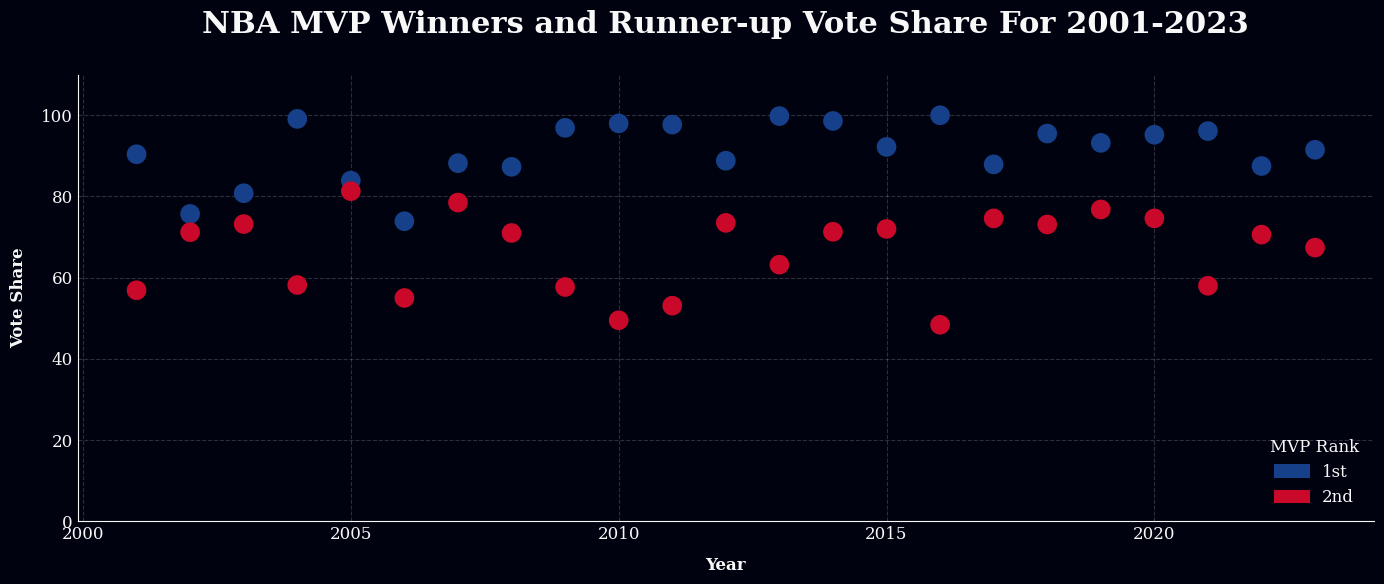

In [68]:
from matplotlib.patches import Patch
fig, ax = plt.subplots(figsize=(14, 6))

colors = ['#17408B', '#C9082A']
sns.scatterplot(x='Year', y='Vote_Share', data=df_nba[df_nba['MVP_rank'].isin([1,2])], hue='MVP_rank', palette=colors, s=200, linewidth=0)
plt.xlabel('Year')
plt.ylabel('Vote Share')
plt.ylim(0, 110)
legend_labels = ['1st', '2nd']
legend_colors = colors
legend_patches = [Patch(color=color, label=label) for color, label in zip(legend_colors, legend_labels)]
plt.legend(handles=legend_patches, title='MVP Rank', loc='lower right')

plt.title('NBA MVP Winners and Runner-up Vote Share For 2001-2023', fontsize=22, pad=30,fontweight='bold')

plt.tight_layout()
sns.despine()

**Key Points:**
- MPV winners consistently receive high vote shares, often close to or exceeding 90%, indicating strong support from NBA voters for their MVP candidacy.
- Despite the subjective nature of MVP voting, the consistently high vote shares for winners suggest a certain level of consensus among voters regarding the most deserving candidate. However, there may still be biases or factors influencing the voting process, such as media coverage, team success, or individual narratives.
- In the early 2000s, several vote shares for both the winner and the runner-up were relatively close, indicating competitive MVP races where multiple players were considered strong contenders for the award. One notable example was in 2005 between the winner Steve Nash and Shaquille O'Neal, where the race was particularly close.

### 📌 Position

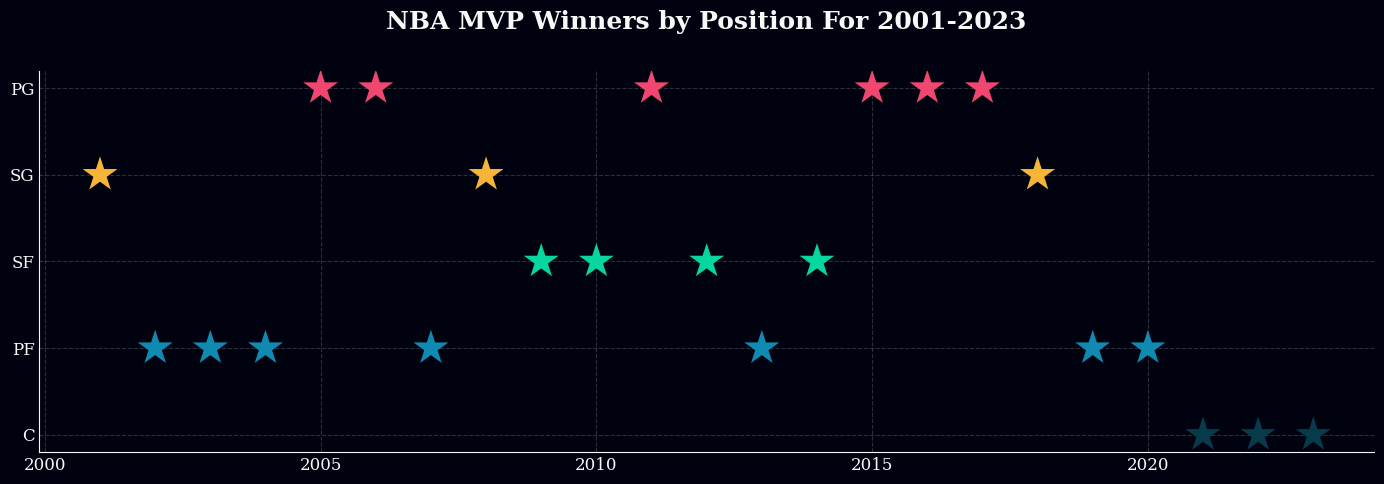

In [69]:
pos_order = ['PG', 'SG', 'SF', 'PF', 'C']
pos_colors = ['#ef476f', '#f7b538', '#06d6a0', '#118ab2', '#073b4c']
temp = df_nba.copy()
temp['Position'] = pd.Categorical(temp['Position'], categories=pos_order, ordered=True)

fig, ax = plt.subplots(figsize=(14, 5))
sns.scatterplot(x='Year', y='Position', data=temp[temp['MVP_rank'] == 1].sort_values('Position'), 
                hue='Position', palette=pos_colors, hue_order=pos_order, s=700, marker='*', linewidth=0)
plt.xlabel('')
plt.ylabel('')
plt.legend().set_visible(False)
plt.title('NBA MVP Winners by Position For 2001-2023', fontsize=18, pad=30,fontweight='bold')

plt.tight_layout()
sns.despine()

**Key Points:**
- MVP winners by positions in order are **PF** (7), **PG** (6), **SF** (4), **SG** (3), & **C** (3).
- The dominance of power forwards in MVP wins suggests the importance of versatility and all-around skill in the modern NBA.
- The relatively lower number of MVP awards for shooting guards and centers could indicate a shift in the league's dynamics towards more versatile and perimeter-oriented playstyles.
- **While power forwards and point guards have historically dominated MVP awards from 2001 to 2023, the last three MVP winners have been centers**. Centers are traditionally known for their defensive presence, rebounding, and rim protection, but recent MVP-winning centers also excel offensively, showcasing versatility in their skill sets.

### 📌 Age

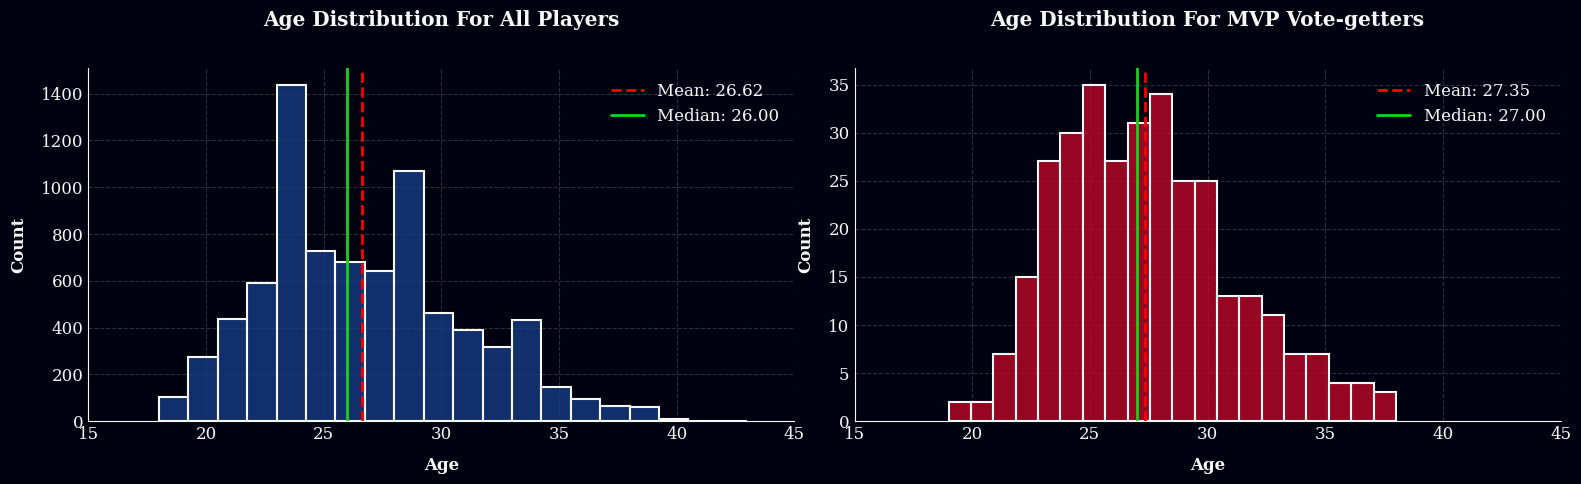

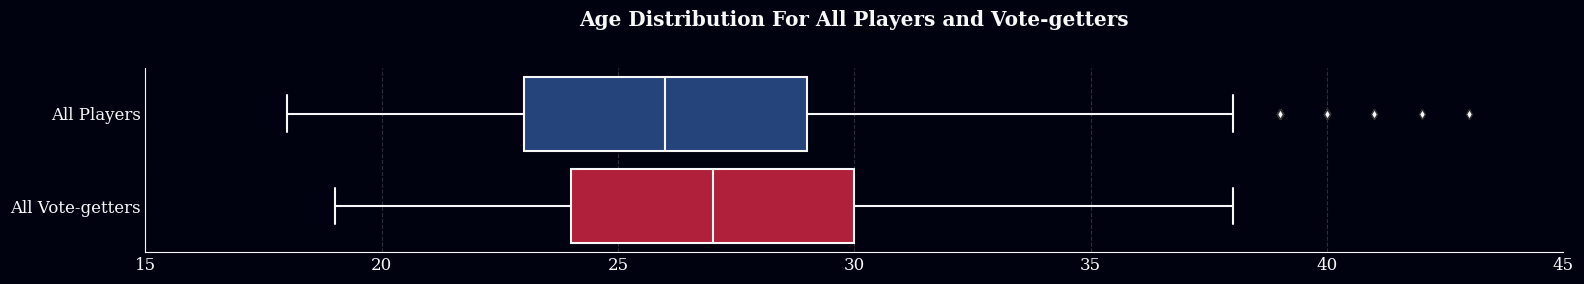

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

colors = ['#17408B', '#C9082A']
sns.histplot(df_nba['Age'], ax=axes[0], color=colors[0], bins=20, linewidth=1.5)
axes[0].axvline(df_nba['Age'].mean(), color='red', linestyle='--', label='Mean: {:.2f}'.format(df_nba['Age'].mean()))
axes[0].axvline(df_nba['Age'].median(), color='#13D519', linestyle='-', label='Median: {:.2f}'.format(df_nba['Age'].median()))
axes[0].legend()
axes[0].set_xlim(15, 45)
axes[0].set_title('Age Distribution For All Players', pad=30, fontweight='bold')
plt.tight_layout()

df_temp = df_nba[df_nba['Vote_Share'] > 0]['Age']
sns.histplot(df_temp, ax=axes[1], color=colors[1], bins=20, linewidth=1.5)
axes[1].axvline(df_temp.mean(), color='red', linestyle='--', label='Mean: {:.2f}'.format(df_temp.mean()))
axes[1].axvline(df_temp.median(), color='#13D519', linestyle='-', label='Median: {:.2f}'.format(df_temp.median()))
axes[1].legend()
axes[1].set_xlim(15, 45)
axes[1].set_title('Age Distribution For MVP Vote-getters', pad=30, fontweight='bold')

fig, ax = plt.subplots(figsize=(16, 3))
sns.boxplot(data=[df_nba['Age'], df_temp], orient='h', palette=colors, linewidth=1.5, flierprops=dict(markerfacecolor='#F8F8F8'),
            boxprops=dict(edgecolor='#F8F8F8'), whiskerprops=dict(color='#F8F8F8'),
            capprops=dict(color='#F8F8F8'), medianprops=dict(color='#F8F8F8'))
plt.yticks(ticks=[0,1], labels=['All Players', 'All Vote-getters'])
plt.title('Age Distribution For All Players and Vote-getters', pad=30, fontweight='bold')
plt.xlim(15, 45)

plt.tight_layout()
sns.despine()

**Key Points:**
- **The mean age of all NBA players is 26.62 years, with a median age of 26 years. For MVP vote-getters specifically, the mean age is slightly higher at 27.35 years, with a median age of 27 years.**
- MVP vote-getters tend to be slightly older on average compared to the overall player population. This could indicate that experience and maturity play significant roles in MVP consideration.
- The higher median and percentile values for MVP vote-getters suggest that NBA players typically hit their prime years in their mid to late twenties, aligning with common knowledge about athletic peak performance.

### 📌 Team

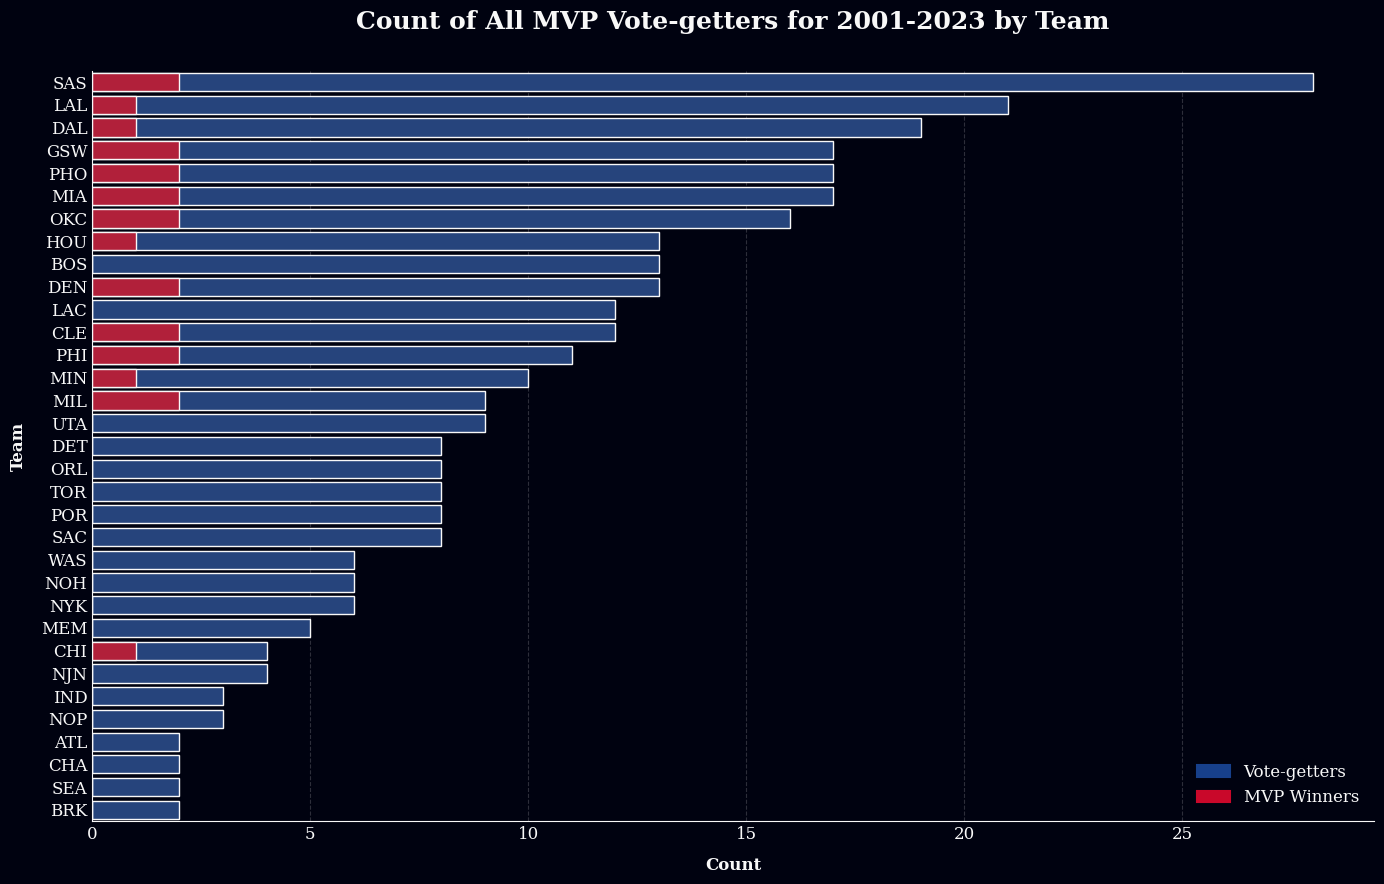

In [71]:
colors = ['#17408B', '#C9082A']
fig, ax = plt.subplots(figsize=(14, 9))
df_temp = df_nba[df_nba['Vote_Share'] > 0]
sns.countplot(y=df_temp['Team'], order=df_temp['Team'].value_counts().index, color=colors[0], linewidth=1)
sns.countplot(y=df_temp[df_temp['MVP_rank'] == 1]['Team'], order=df_temp['Team'].value_counts().index ,color=colors[1], linewidth=1)
plt.xlabel('Count')
plt.ylabel('Team')
plt.title('Count of All MVP Vote-getters for 2001-2023 by Team', fontsize=18, pad=30,fontweight='bold')

legend_labels = ['Vote-getters', 'MVP Winners']
legend_colors = colors
legend_patches = [Patch(color=color, label=label) for color, label in zip(legend_colors, legend_labels)]
plt.legend(handles=legend_patches, title='')

plt.tight_layout()
plt.show()

**Key Points:**
- Among all NBA teams, the **San Antonio Spurs (SAS)** have the highest number of MVP vote-getters with 28, indicating consistent recognition of their players' performance at an elite level by the voting panel.
- Other teams with significant representation among MVP vote-getters include the **Los Angeles Lakers (LAL)** and the **Dallas Mavericks (DAL)** with 21 and 19 MVP vote-getters, respectively.
- The distribution of MVP vote-getters reflects the prominence of certain franchises in consistently producing standout players who receive recognition for their contributions to their teams.
- The disparity between the number of MVP vote-getters and actual MVP winners for each team suggests that while some teams consistently produce players recognized as MVP candidates, winning the award requires exceptional individual performance and often significant team success.

### 📌 MVP Winning History

This is a historical record of all players in every season who have won the NBA MVP award from 2001-2023. This provides another perspective on the impact of winning an MVP and the likelihood of winning it again.

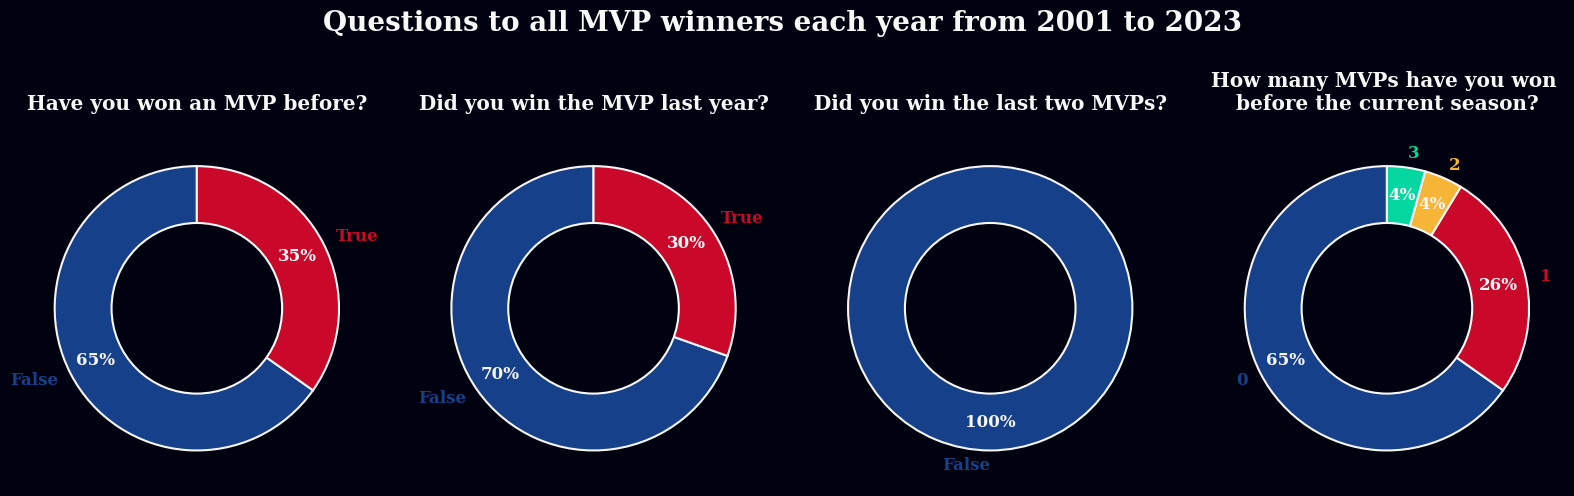

In [72]:
data = df_nba[df_nba['MVP_rank'] == 1]
colors = ['#17408B', '#C9082A', '#f7b538', '#06d6a0']
title = ['Have you won an MVP before?', 'Did you win the MVP last year?', 'Did you win the last two MVPs?', 'How many MVPs have you won \nbefore the current season?']

column_indices = range(4)
fig, axes = plt.subplots(1, 4, figsize=(16, 5))
axes = axes.flatten()

for i, ax in zip(column_indices, axes):
    patches, texts, pcts = ax.pie(data.iloc[:, i+61].value_counts(), labels=data.iloc[:, i+61].value_counts().index, autopct='%.0f%%', colors=colors,
                                   wedgeprops={'linewidth': 1.5, 'edgecolor': '#F5F5F5'},
                                   textprops={'size': 'medium'},
                                   startangle=90, pctdistance=0.8, labeldistance=1.1)
    
    centre_circle = plt.Circle((0, 0), 0.60, fc='#000210', linewidth=1.5)
    ax.add_artist(centre_circle)
    
    for j, patch in enumerate(patches):
        texts[j].set_color(patch.get_facecolor())
    plt.setp(pcts, color='#F5F5F5', fontweight='bold', fontsize=12)
    plt.setp(texts, fontweight='bold')
    ax.set_title(title[i])
plt.suptitle('Questions to all MVP winners each year from 2001 to 2023', fontweight='bold', fontsize=20, y=1.05)
    
plt.tight_layout()
sns.despine()

**Key Points:**
- The presence of first-time MVP winners (70%) suggests that there is ample opportunity for new talent to emerge and be recognized as the league's most valuable player. This highlights the dynamic nature of NBA talent and the potential for breakout performances to capture the MVP award.
- Only 26% of MVP winners had won the MVP in the previous year, indicating that *back-to-back* MVP wins are relatively uncommon.
- None of the MVP winners had won the MVP in both the previous year and the year before, indicating a lack of *three-peat* MVP wins from 2001 to 2023. This suggests a competitive landscape where the MVP title is not monopolized by a select few players over consecutive seasons. However, this could also indicate voter fatigue, where voters become less inclined to vote for the same candidate repeatedly due to a desire for variety or recognition of new achievements.

## 2. Players Basic Stats

Before analyzing player basic stats, lets make player groups to help identifying what make player *"more valuable"*. The groups will be:
1. **MVP winners**
2. **All MVP vote-getters** (*excluding the winners*)
3. **All players** (*excluding MVP vote-getters*)

In [73]:
df_nba = df_transform.copy()

In [74]:
viz_nba = df_nba.copy()

In [75]:
newlist = []
for i in range(viz_nba.shape[0]):
    if viz_nba['MVP_rank'][i] == 1:
        temp = 'MVP'
    elif viz_nba['MVP_rank'][i] == 0:
        temp = 'All Players'
    else:
        temp = 'Vote-getters'
    newlist.append(temp)
viz_nba['player_groups'] = newlist
df_nba['player_groups'] = newlist

In [76]:
viz_nba = viz_nba[viz_nba['Year'] != 2024]

### 📌 Basic Stats

In [79]:
plt.rcParams.update({                 
    'axes.spines.top': False,          
    'axes.spines.right': False,
    'axes.spines.left': False})

def BoxPlots(df, col_start, col_end, axrows, axcols, fig_x, fig_y, title):

    fig, axes = plt.subplots(axrows, axcols, figsize=(fig_x, fig_y))
    if axrows * axcols > 1:
        axes = axes.flatten()

    colors = ['#17408B' ,'#B4B4B4', '#C9082A']
    order = ['All Players', 'Vote-getters', 'MVP']
    for i, col in enumerate(df.columns[col_start:col_end]):
        sns.boxplot(x=col, y='player_groups', data=df, ax=axes[i], palette=colors, order=order, linewidth=1.5, flierprops=dict(markerfacecolor='#EAEAEA'),
                   boxprops=dict(edgecolor='#EAEAEA'), whiskerprops=dict(color='#EAEAEA'), capprops=dict(color='#EAEAEA'), medianprops=dict(color='#EAEAEA'))
        axes[i].set_xlabel(col, fontsize=15)
        axes[i].set_ylabel('')
        if i not in [0, 3, 6, 9]:
            axes[i].set_yticks([])
    plt.suptitle(title, fontsize=24, fontweight='bold', y=1.025)

    plt.tight_layout()
    plt.show()

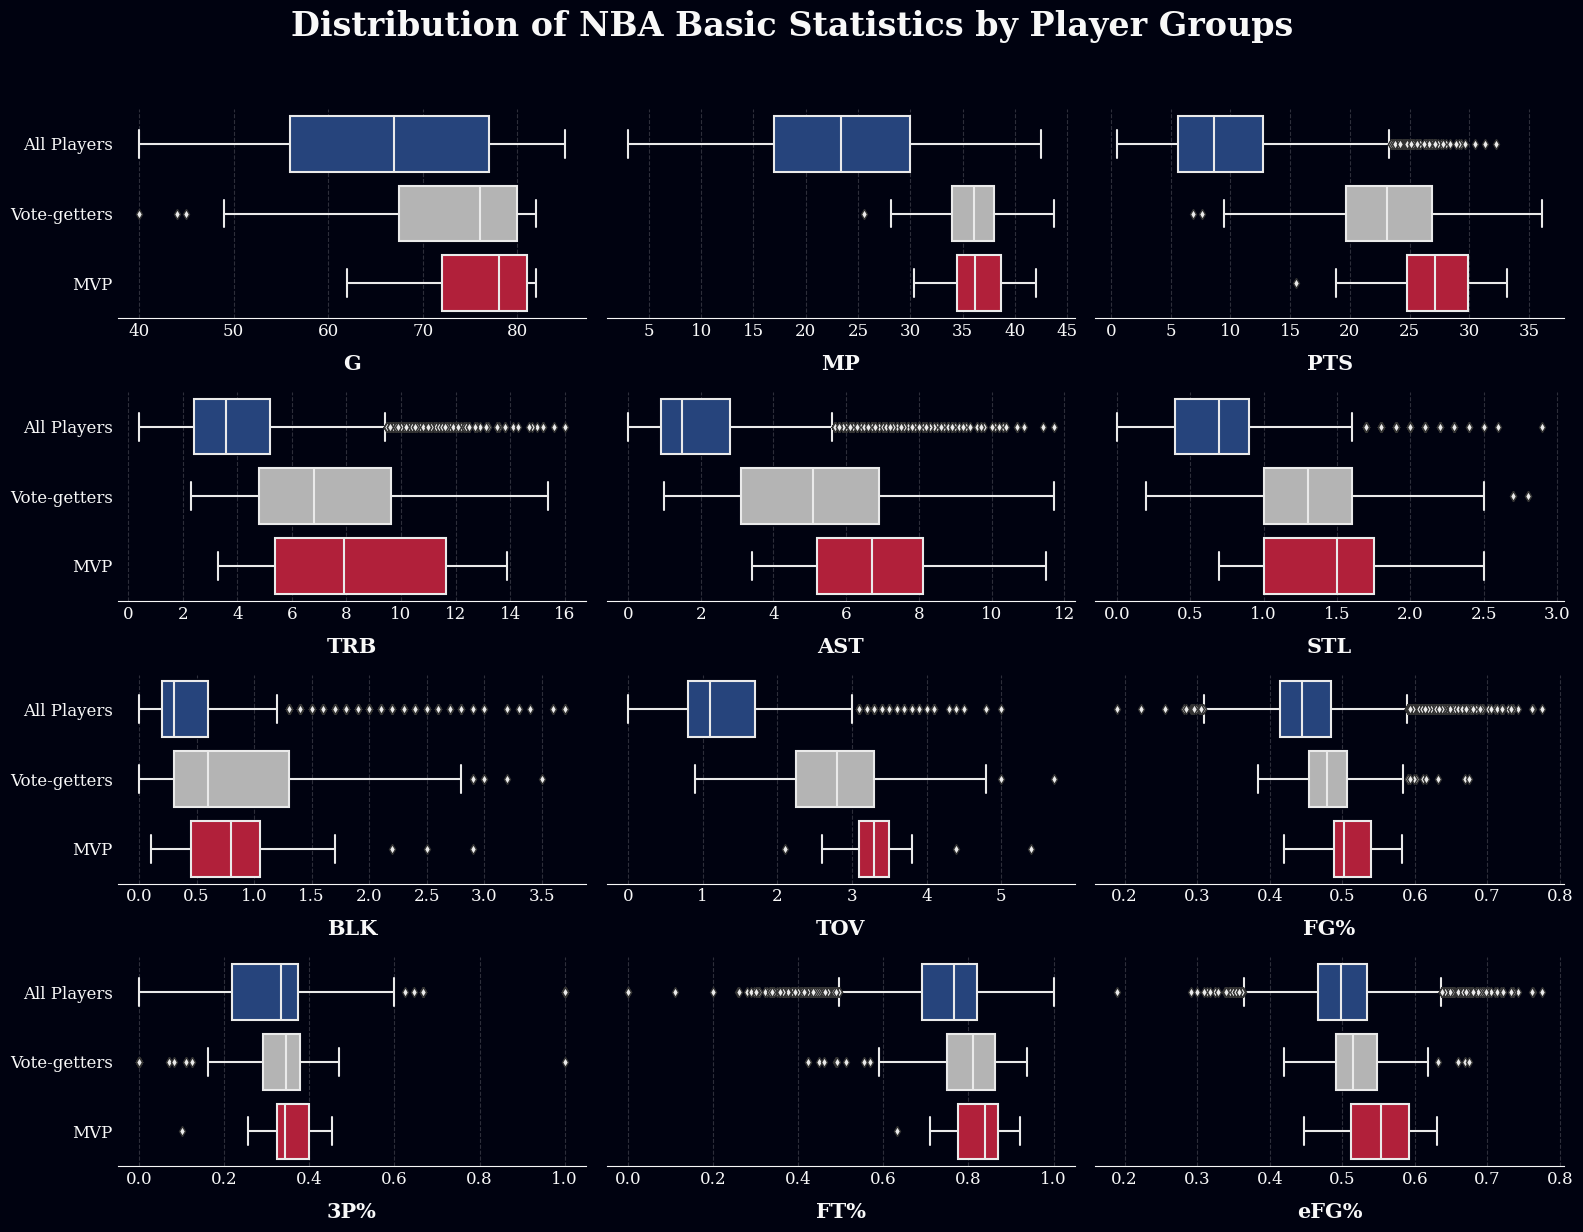

In [80]:
BoxPlots(viz_nba, col_start=5, col_end=17, axrows=4, axcols=3, fig_x=16, fig_y=12, 
         title="Distribution of NBA Basic Statistics by Player Groups")

**Key Points:**
- Across all basic NBA statistics (e.g., points, rebounds, assists, field goal percentage), there's a noticeable difference between the median and percentile values for all players, MVP vote-getters, and actual MVP winners.
- MVP winners exhibit superior performance across various statistical categories compared to both MVP vote-getters and all players.
- **Statistical excellence, particularly in scoring, shooting efficiency, playmaking, and defensive contributions, appears to be a common trait among MVP winners.**

### 📌 Standardized Basic Stats

Compared to the previous data, where actual player statistics were used, these rankings provide a more standardized comparison across seasons by accounting for the relative performance within each season.

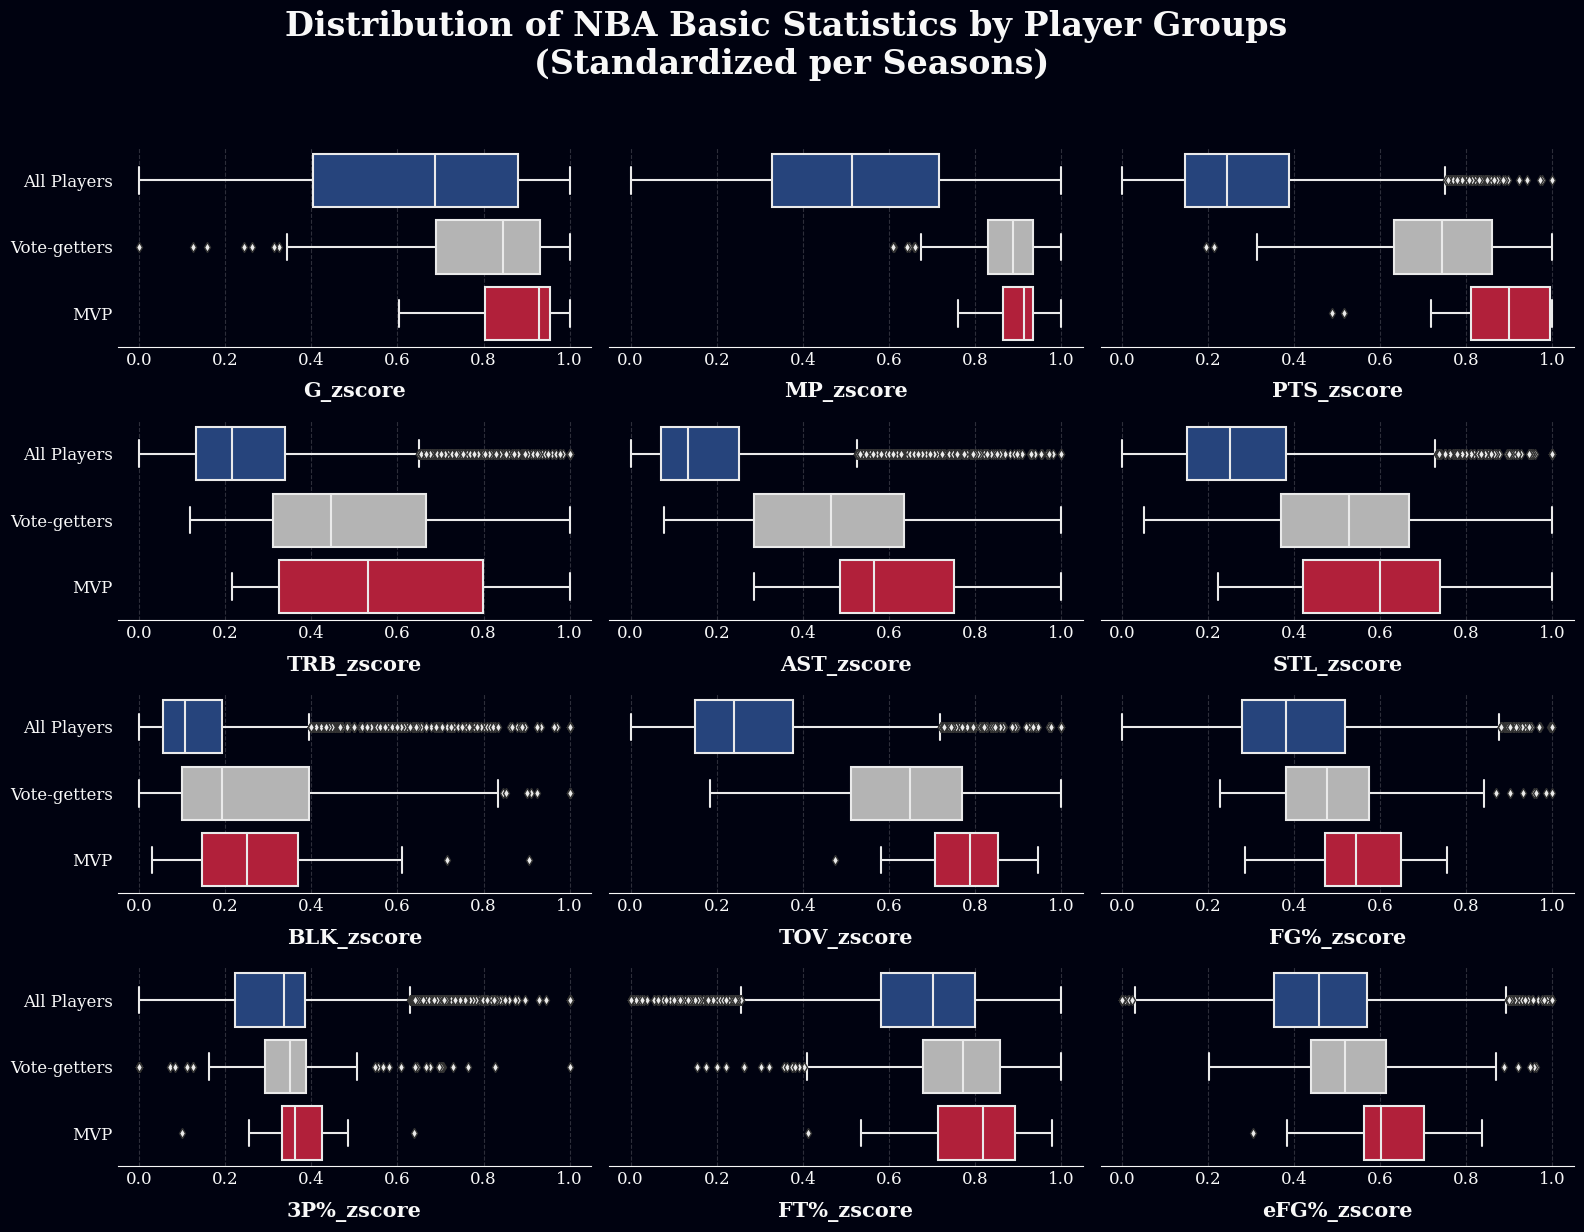

In [81]:
BoxPlots(viz_nba, col_start=32, col_end=44, axrows=4, axcols=3, fig_x=16, fig_y=12, 
         title="Distribution of NBA Basic Statistics by Player Groups \n(Standardized per Seasons)")

**Key Points:**
- The use of rankings first per season provides a standardized comparison across seasons, allowing for a more balanced assessment of player performance over time.
- MVP winners consistently exhibit superior performance across various statistical categories compared to both MVP vote-getters and all players, emphasizing their impact and contribution to their teams' success.
- To be more specific, MVP winners exhibit superior shooting efficiency overall, including both two-point and three-point shots, compared to MVP vote-getters and all players.
- **There are four statistics where MVP winners tend to fall within the 80th percentile at the lowest, namely MP, AST, TOV, and PTS. This indicates that:**
    1. MVP winners significantly log more minutes per game, indicating their importance and impact on their respective teams' success.
    2. MVP winners significantly record more assists per game, highlighting their playmaking ability and facilitating role within their teams.
    3. MVP winners significantly have higher number in turnovers, likely due to their high usage rates and playmaking responsibilities.
    4. MVP winners consistently score more points per game, highlighting their offensive prowess and scoring ability.

### ⚙️ Basic Stats - Feature Engineering

The `G` statistic alone doesn't fully represent a player's value. There are many *role players* who consistently play a large number of games because they excel in their role as supplements to star players. Therefore, we will use the basic stats to supplement the `G` statistic. We will also add another feature that calculates total basic stats based on player position. For guards, we will use assists and turnovers, while for centers, we will use rebounds.

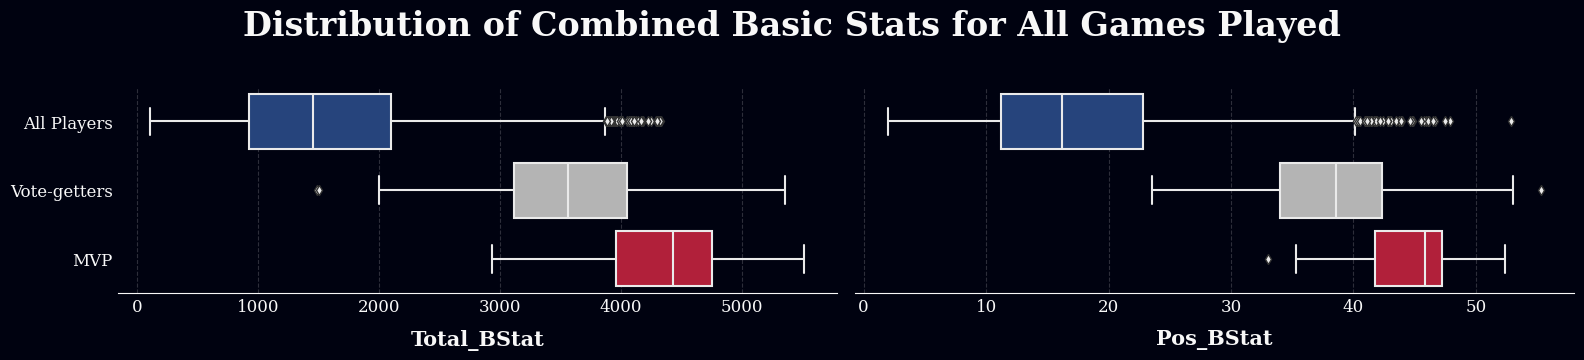

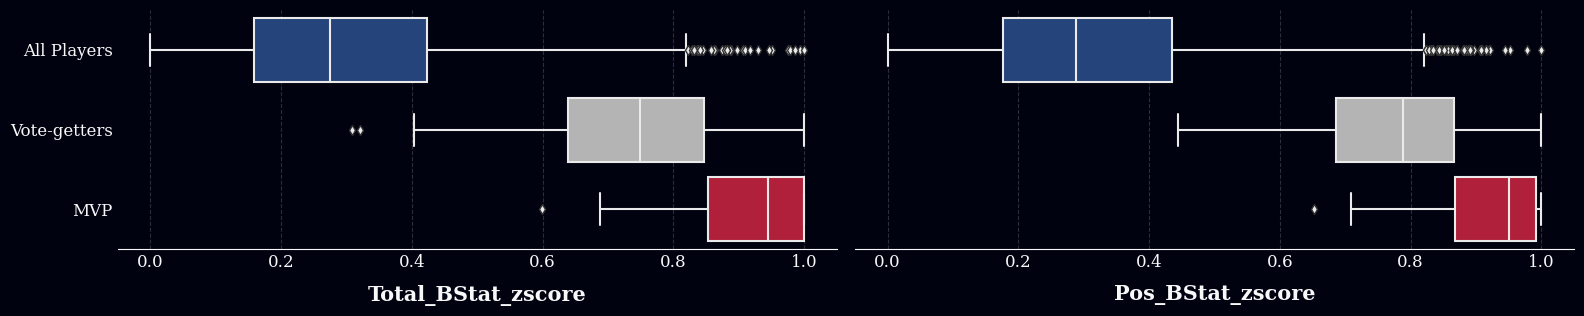

In [82]:
df_nba['Total_BStat'] = (df_nba['PTS'] + df_nba['TRB'] + df_nba['AST'] + df_nba['TOV'] + df_nba['STL'] * 5 + df_nba['BLK'] * 5) * df_nba['G']

df_nba['Pos_BStat'] = df_nba.apply(lambda row: (row['PTS'] + row['AST'] + row['TOV'] + (row['STL'] + row['BLK']) * 2.5) if row['Position'] in ['PG', 'SG'] \
                                   else ((row['PTS'] + row['TRB'] + (row['STL'] + row['BLK']) * 2.5) if row['Position'] in ['PF', 'C'] \
                                   else (row['PTS'] + max(row['TRB'], row['AST'] + row['TOV']) + (row['STL'] + row['BLK']) * 2.5)), axis=1)

StandarizedStats(df_nba, col_begin=df_nba.shape[1]-2, col_end=df_nba.shape[1])

BoxPlots(df_nba, col_start=df_nba.shape[1]-4, col_end=df_nba.shape[1]-2, axrows=1, axcols=2, fig_x=16, fig_y=3.5, 
         title="Distribution of Combined Basic Stats for All Games Played")
BoxPlots(df_nba, col_start=df_nba.shape[1]-2, col_end=df_nba.shape[1], axrows=1, axcols=2, fig_x=16, fig_y=3.5, 
         title="")

Next, there are two major defensive statistics: `STL` (steals) and `BLK` (blocks). Let's examine the graph below.

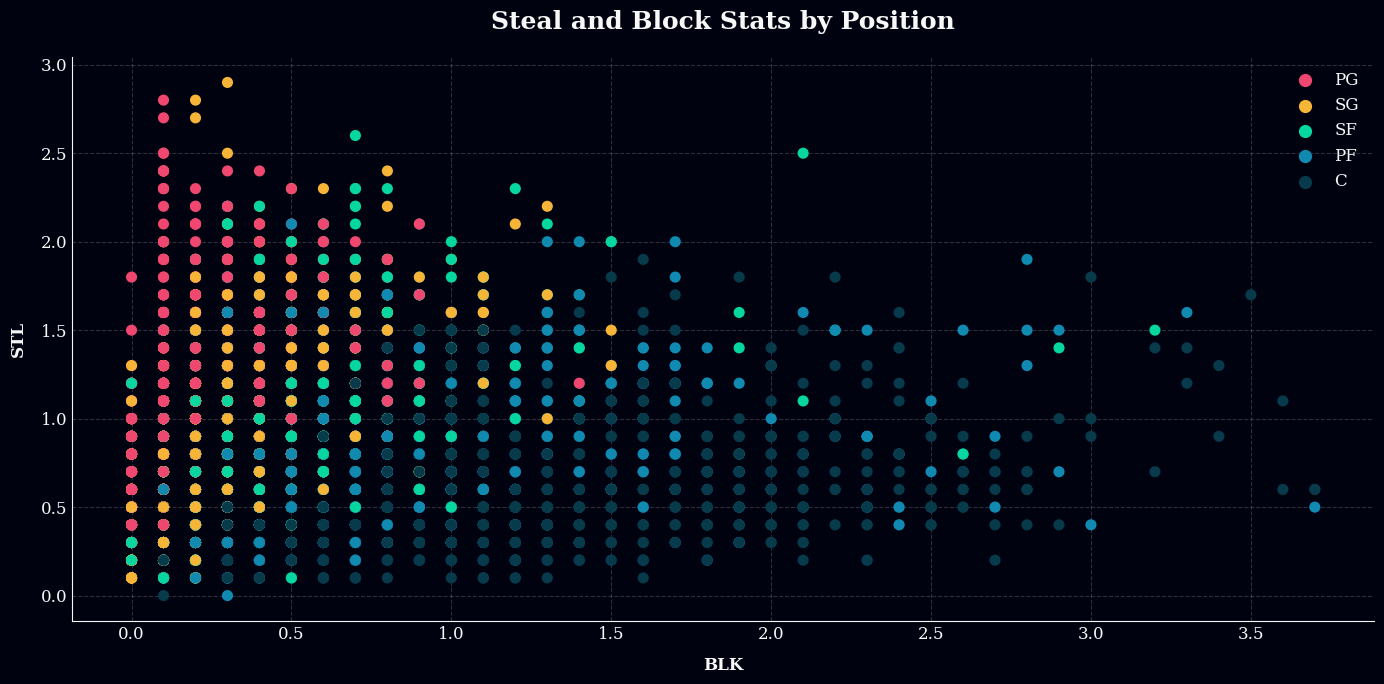

In [83]:
fig, ax = plt.subplots(figsize=(14, 7))
sns.scatterplot(x='BLK', y='STL', data=df_nba, hue='Position', palette=pos_colors, hue_order=pos_order, linewidth=0)
plt.xlabel('BLK')
plt.ylabel('STL')
plt.legend()
plt.title('Steal and Block Stats by Position', fontsize=18, pad=20,fontweight='bold')

plt.tight_layout()
sns.despine()

When these stats are used to compare players, it can be unfair because these stats are position-oriented. This means that some positions will be more favorable for accumulating these stats than others. Therefore, these stats will be combined to create a new feature that is representative of defensive performance.

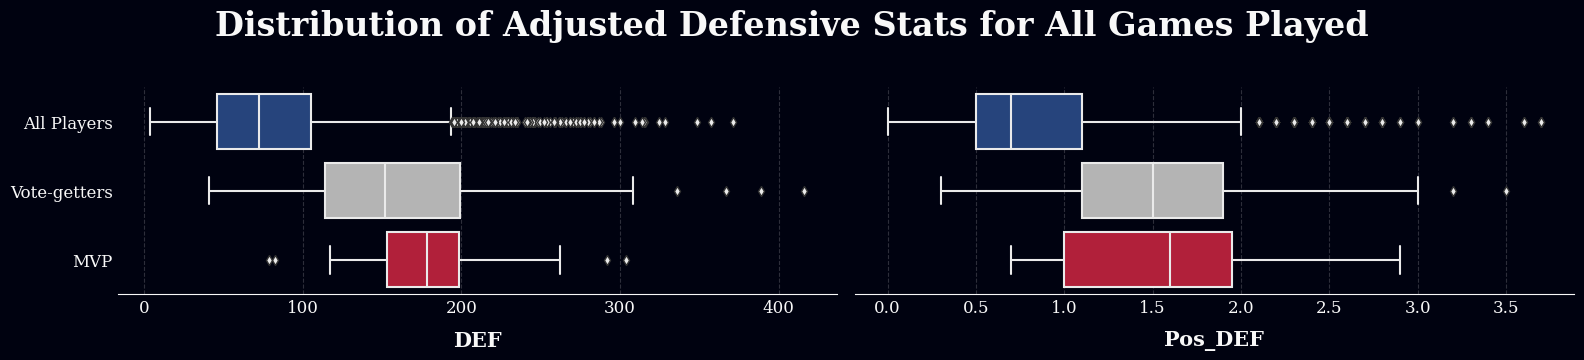

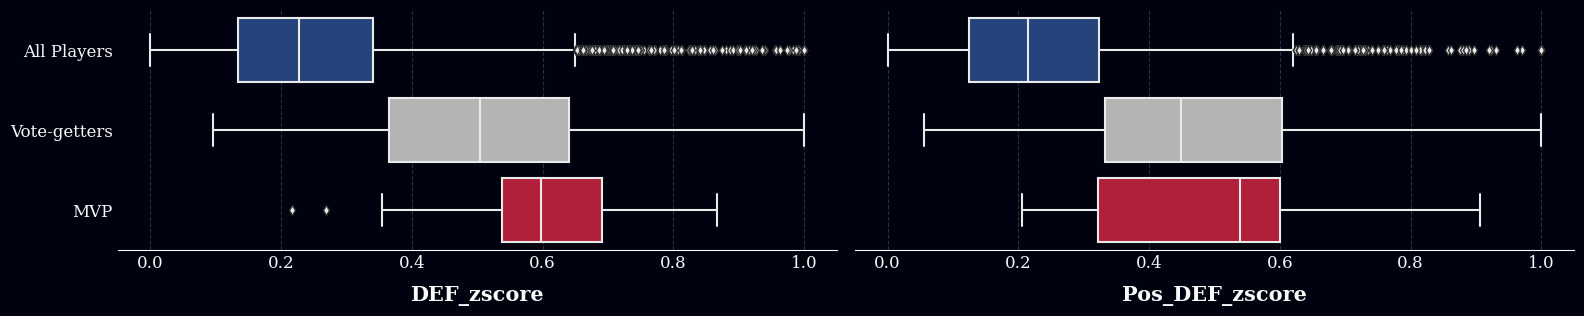

In [84]:
#combined defensive stats
df_nba['DEF'] = (df_nba['BLK'] + df_nba['STL']) * df_nba['G']
#positional-based casting
df_nba['Pos_DEF'] = df_nba.apply(lambda row: row['STL'] if row['Position'] in ['PG', 'SG'] \
                                  else (row['BLK'] if row['Position'] in ['PF', 'C'] else max(row['BLK'], row['STL'])), axis=1)

StandarizedStats(df_nba, col_begin=df_nba.shape[1]-2, col_end=df_nba.shape[1])

BoxPlots(df_nba, col_start=df_nba.shape[1]-4, col_end=df_nba.shape[1]-2, axrows=1, axcols=2, fig_x=16, fig_y=3.5, 
         title="Distribution of Adjusted Defensive Stats for All Games Played")
BoxPlots(df_nba, col_start=df_nba.shape[1]-2, col_end=df_nba.shape[1], axrows=1, axcols=2, fig_x=16, fig_y=3.5, 
         title="")

## 3. Players Advanced Stats

### 📌 Advanced Stats

The statistics provided represent values for all NBA players, MVP vote-getters, and actual MVP winners for various advanced/analytical NBA metrics. These advanced statistics offer deeper insights into player performance beyond traditional box score metrics, focusing on efficiency, usage, and impact on both ends of the court.

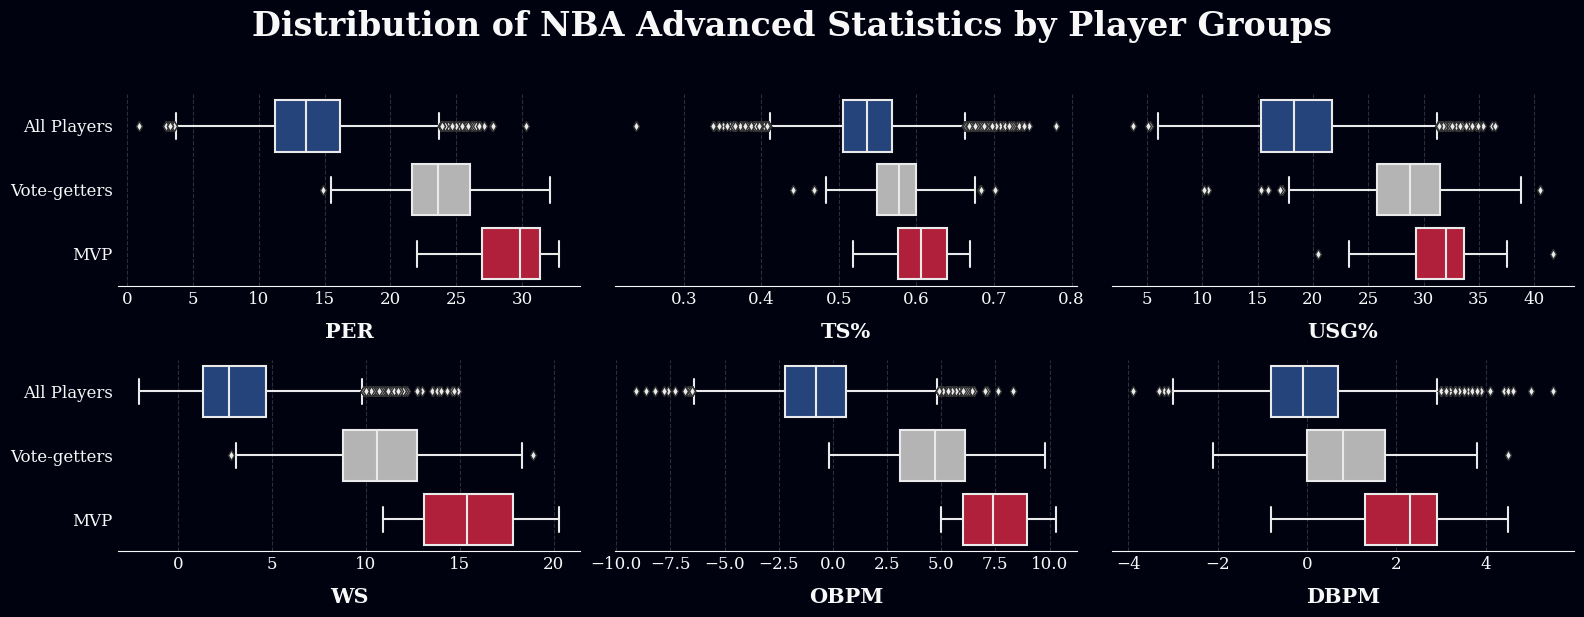

In [85]:
BoxPlots(viz_nba, col_start=17, col_end=23, axrows=2, axcols=3, fig_x=16, fig_y=6, 
         title="Distribution of NBA Advanced Statistics by Player Groups")

**Specific Findings by Statistic:**

1. **Player Efficiency Rating (PER):** \
   MVP winners have the highest median and percentile values in PER, indicating their overall impact and efficiency on the court.
2. **True Shooting Percentage (TS%):** \
MVP winners demonstrate superior shooting efficiency, reflecting their ability to score efficiently from all areas of the court.
3. **Usage Percentage (USG%):** \
MVP winners and vote-getters have median and percentile values in USG%, indicating their higher involvement and usage in their teams' offensive schemes compared to all players.
4. **Win Shares (WS):** \
MVP winners consistently contribute more to their teams' success with higher median and percentile values, showcasing their overall impact on winning games.

**Key Points:**
- Advanced/analytical statistics provide a more nuanced understanding of player performance, focusing on efficiency, usage, and impact on both ends of the court.
- MVP winners consistently demonstrate superior performance across various advanced metrics compared to both MVP vote-getters and all players, emphasizing their overall impact and contribution to their teams' success.

### 📌 Standardized Advanced Stats

The statistics provided represent values for all NBA players, MVP vote-getters, and actual MVP winners for various advanced/analytical NBA metrics, but this time the players are ranked first per season before the statistics are aggregated. These rankings first per season offer a standardized comparison across seasons by accounting for the relative performance within each season, similar to the previous advanced statistics.

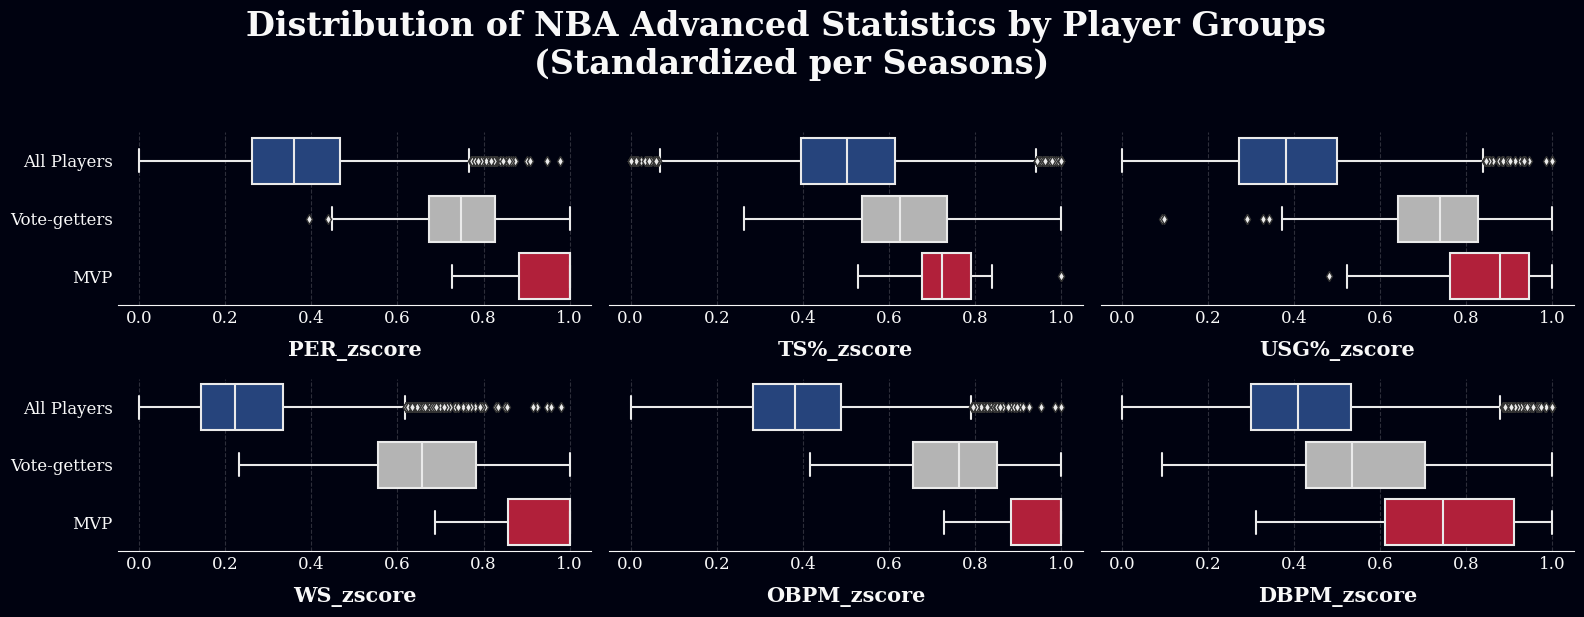

In [86]:
BoxPlots(viz_nba, col_start=44, col_end=50, axrows=2, axcols=3, fig_x=16, fig_y=6, 
         title="Distribution of NBA Advanced Statistics by Player Groups \n(Standardized per Seasons)")

**Key Points:**
- MVP winners, and to some extent, vote-getters consistently rank at the highest end of the percentile across various advanced metrics compared to all other players. This underscores their significant impact and contribution to their teams' success.
- **MVP winners exhibit extreme percentile values, with the lowest percentiles around 90 for certain metrics such as PER, USG%, WS, and OBPM. This suggests that these four stats are often given more weight in MVP voting.**
- MVP winners with extremely high percentile values demonstrate unparalleled efficiency, usage, offensive impact, and defensive prowess, setting them apart as elite performers in those areas.

### ⚙️ Advanced Stats - Feature Engineering

> Box Plus/Minus (`BPM`) is a basketball box score-based metric that estimates a basketball player’s contribution to the team when that player is on the court. It is based only on the information in the traditional basketball box score. League average is defined as 0.0, meaning 0 points above average or below average. Because above-average players play more minutes, there are far more below-average players than above-average players in the league at any time. A value of +5.0 means the team is 5 points per 100 possessions better with the player on the floor than with average production from another player.

Let's examine the graph below.

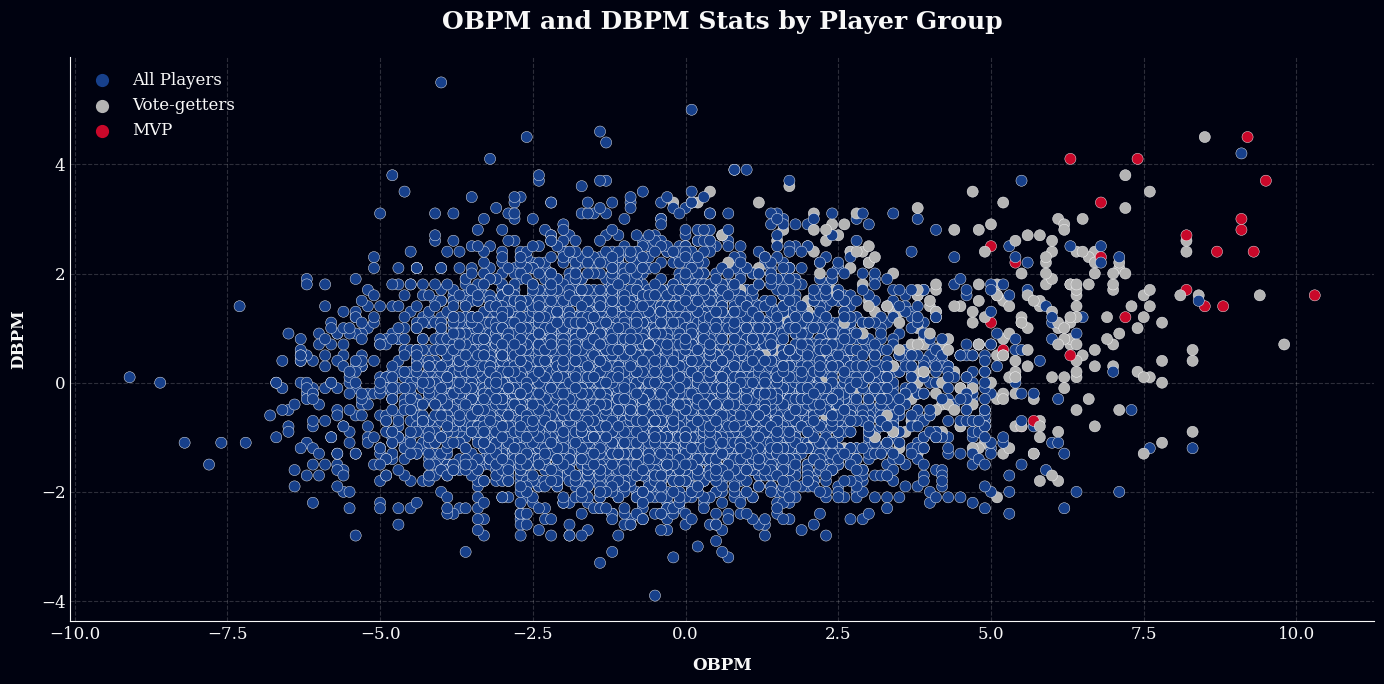

In [87]:
fig, ax = plt.subplots(figsize=(14, 7))
colors = ['#17408B' ,'#B4B4B4', '#C9082A']
order = ['All Players', 'Vote-getters', 'MVP']
sns.scatterplot(x='OBPM', y=df_nba['DBPM'], data=df_nba, hue='player_groups', palette=colors, hue_order=order, linewidth=0.3)
plt.xlabel('OBPM')
plt.ylabel('DBPM')
plt.xlim()
plt.legend()
plt.title('OBPM and DBPM Stats by Player Group', fontsize=18, pad=20,fontweight='bold')

plt.tight_layout()
sns.despine()

From the graph, it's undeniable that `OBPM` can provide more insight into a player's value than `DBPM`. A player can receive MVP votes solely based on their offensive performance, even if they have little defensive impact while on the court. However, it's worth noting that many MVP winners also have high `DBPM`, which sets them apart from other vote-getters. Therefore, `DBPM` is still a useful statistic, and we will combine it with `OBPM` to capture its full effect.

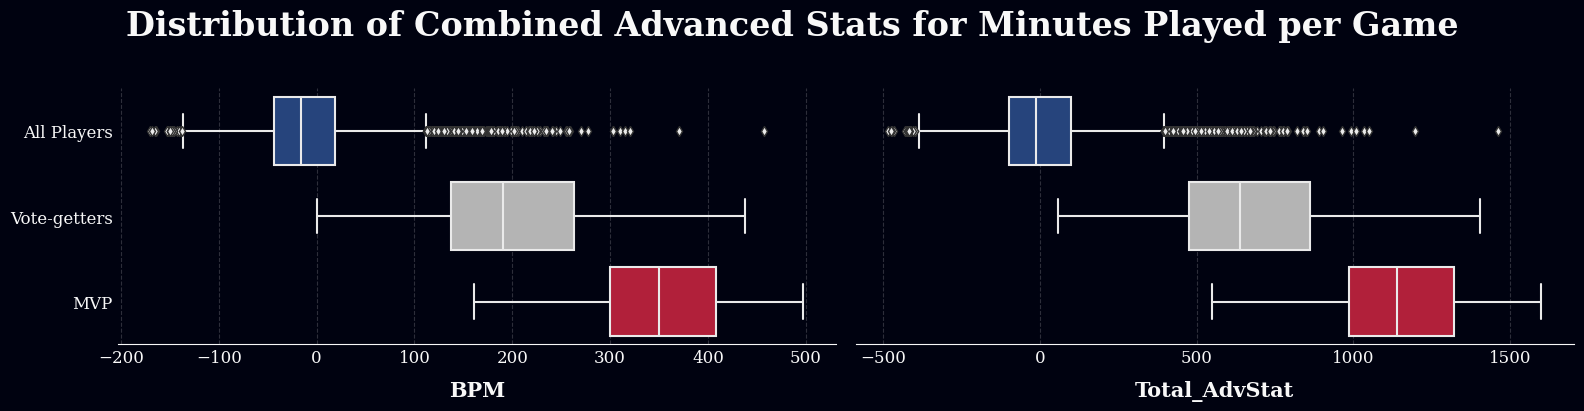

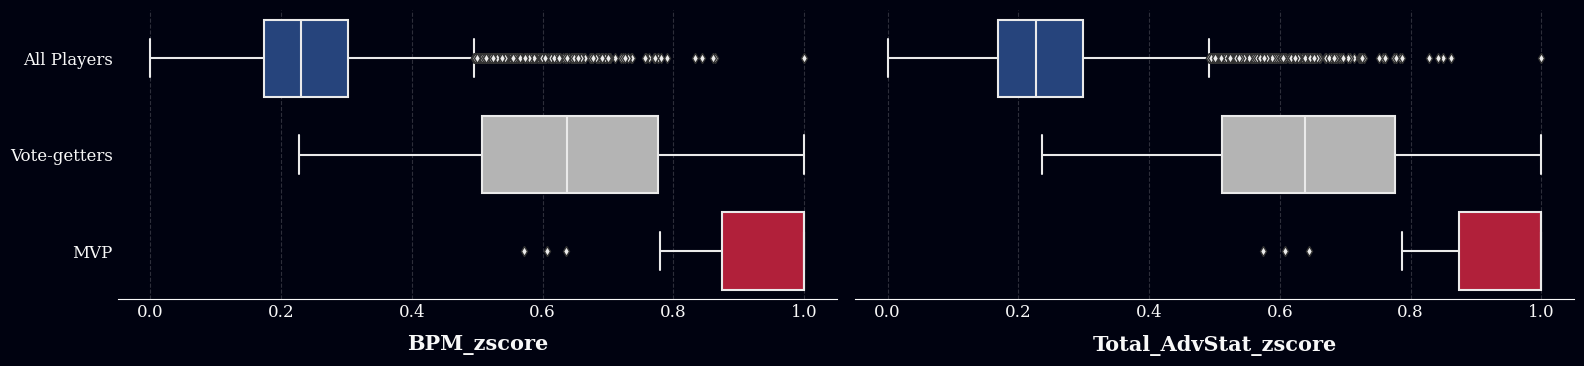

In [88]:
df_nba['BPM'] = (df_nba['OBPM'] + df_nba['DBPM']) * df_nba['MP']
df_nba['Total_AdvStat'] = df_nba['BPM'] * 3 + df_nba['PER'] + df_nba['WS'] * 2 + df_nba['USG%']

StandarizedStats(df_nba, col_begin=df_nba.shape[1]-2, col_end=df_nba.shape[1])

BoxPlots(df_nba, col_start=df_nba.shape[1]-4, col_end=df_nba.shape[1]-2, axrows=1, axcols=2, fig_x=16, fig_y=4, 
         title="Distribution of Combined Advanced Stats for Minutes Played per Game")
BoxPlots(df_nba, col_start=df_nba.shape[1]-2, col_end=df_nba.shape[1], axrows=1, axcols=2, fig_x=16, fig_y=4, 
         title="")

Next, the `TS%` and `USG%` statistics alone also don't fully represent a player's value. There are many players who have high `TS%` because they only take a few shot attempts around the rim. Similarly, there are many players who have high `USG%`, but don't produce at a high level. Therefore, these two stats will be supplemented by another statistic to provide more useful insight into player performance.

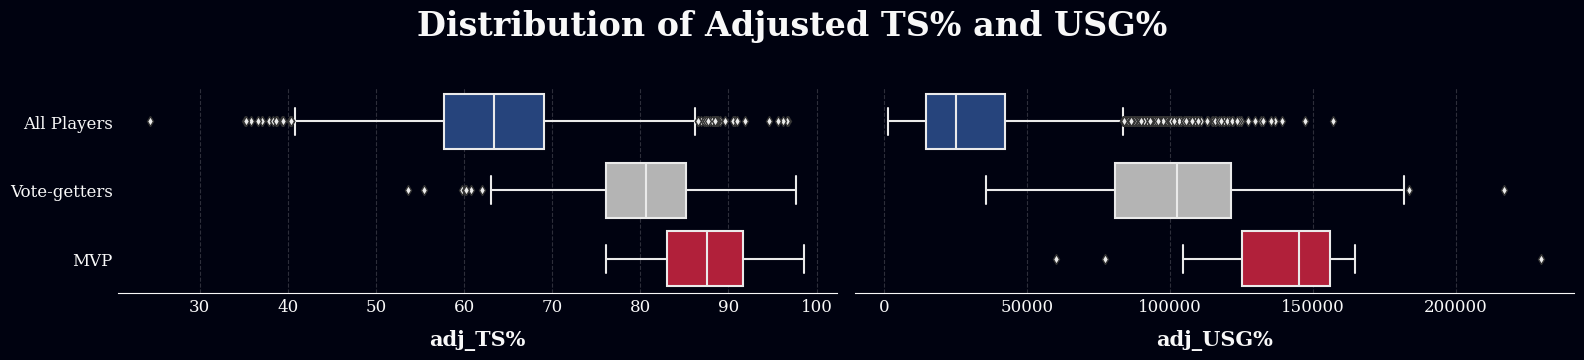

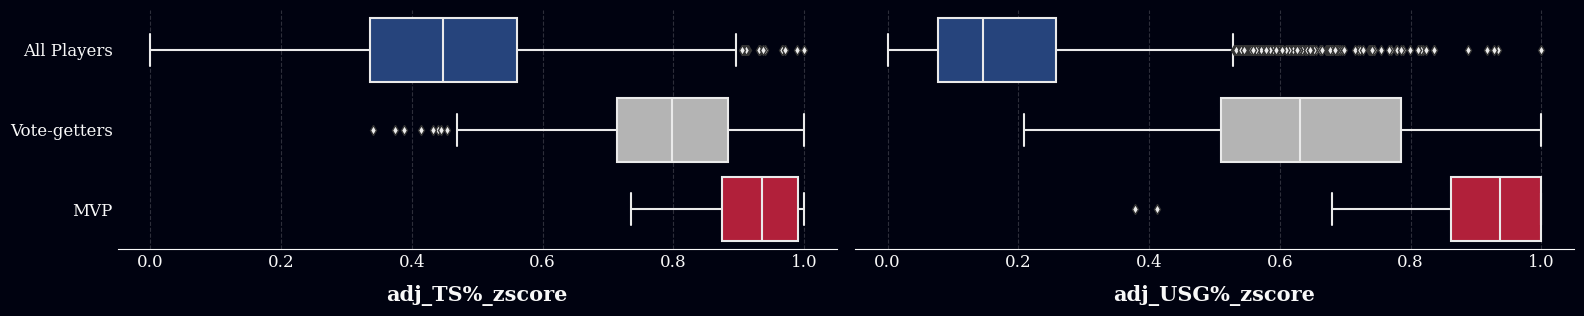

In [89]:
#Adjusted TS% calculated using the total points scored throughout the season
df_nba['adj_TS%'] = (df_nba['PTS'] + df_nba['TS%'] * 100)
#Adjusted USG% calculated using the total points and assists throughout the season
df_nba['adj_USG%'] = (df_nba['Total_BStat']) * (df_nba['USG%'])

StandarizedStats(df_nba, col_begin=df_nba.shape[1]-2, col_end=df_nba.shape[1])

BoxPlots(df_nba, col_start=df_nba.shape[1]-4, col_end=df_nba.shape[1]-2, axrows=1, axcols=2, fig_x=16, fig_y=3.5, 
         title="Distribution of Adjusted TS% and USG%")
BoxPlots(df_nba, col_start=df_nba.shape[1]-2, col_end=df_nba.shape[1], axrows=1, axcols=2, fig_x=16, fig_y=3.5, 
         title="")

## 4. Teams Stats

### 📌 Teams Stats

The statistics provided represent values for all NBA players, MVP vote-getters, and actual MVP winners for various advanced/analytical NBA metrics. These advanced statistics offer deeper insights into player performance beyond traditional box score metrics, focusing on efficiency, usage, and impact on both ends of the court.

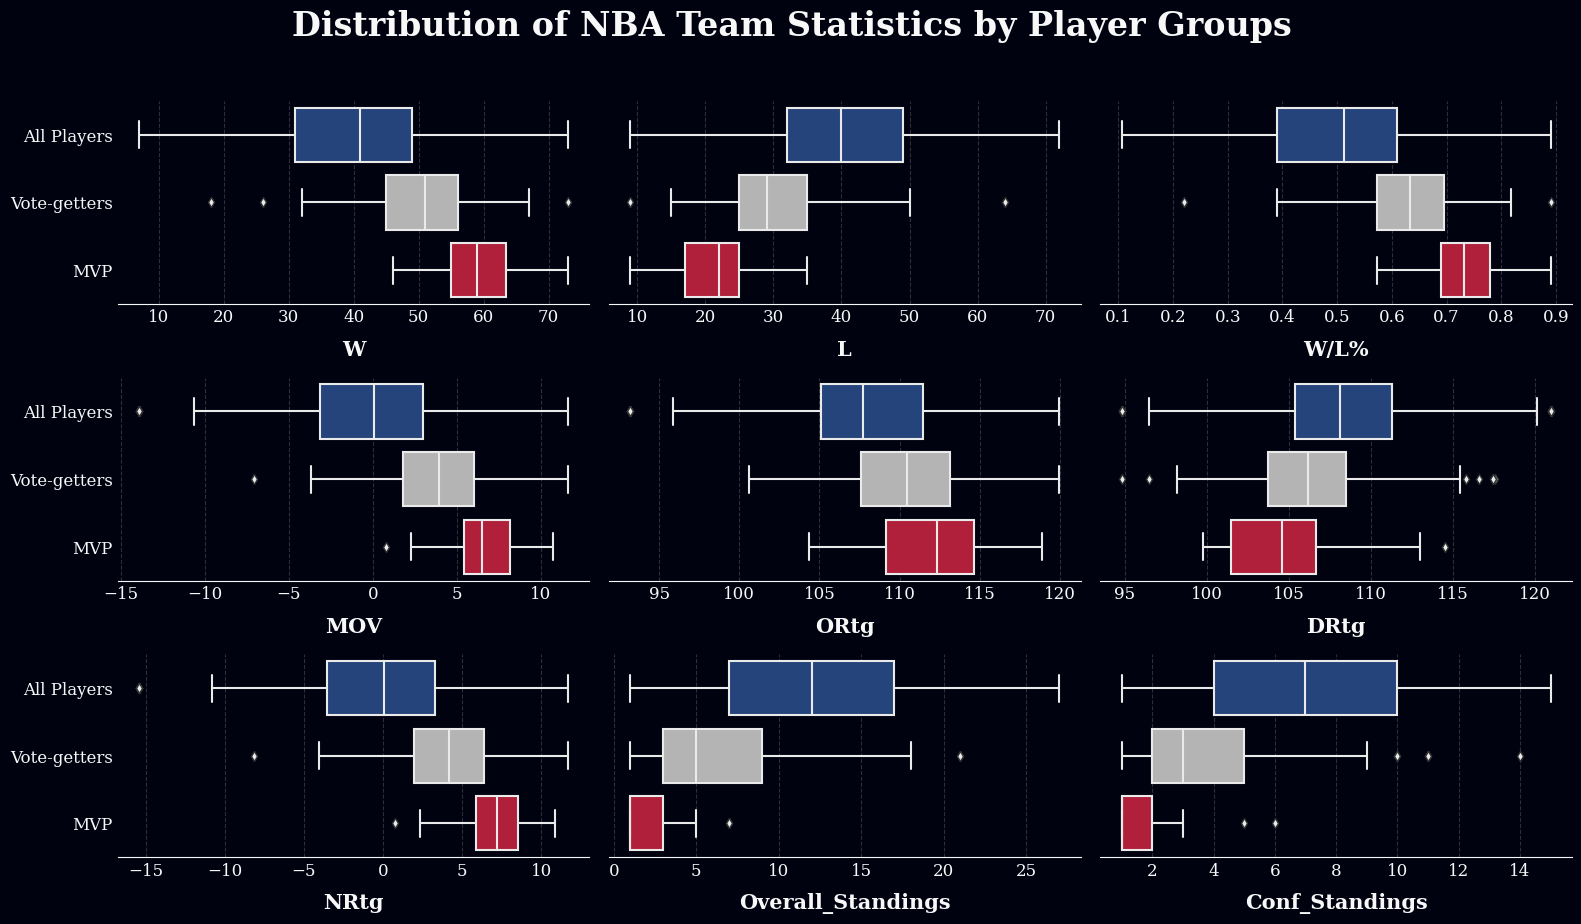

In [90]:
BoxPlots(viz_nba, col_start=23, col_end=32, axrows=3, axcols=3, fig_x=16, fig_y=9, 
         title="Distribution of NBA Team Statistics by Player Groups")

**Key Points:**
- MVP-winning teams demonstrate superior performance across various team-oriented metrics, highlighting the significant impact of elite talent on team success.
- Teams with MVP-caliber players tend to outperform their counterparts in terms of offensive and defensive efficiency, margin of victory, win-loss records, and overall and conference standings.
- **Higher win totals, lower loss totals, and higher win-loss percentages among MVP-winning teams underscore their significant contributions to their teams' success in terms of securing victories and achieving a better win-loss record.**
- **Higher overall and conference standings among MVP-winning teams reflect their ability to elevate team performance and competitiveness, positioning them as key leaders in guiding their teams to success within their respective conferences and the league as a whole.**

### 📌 Standarized Teams Stats

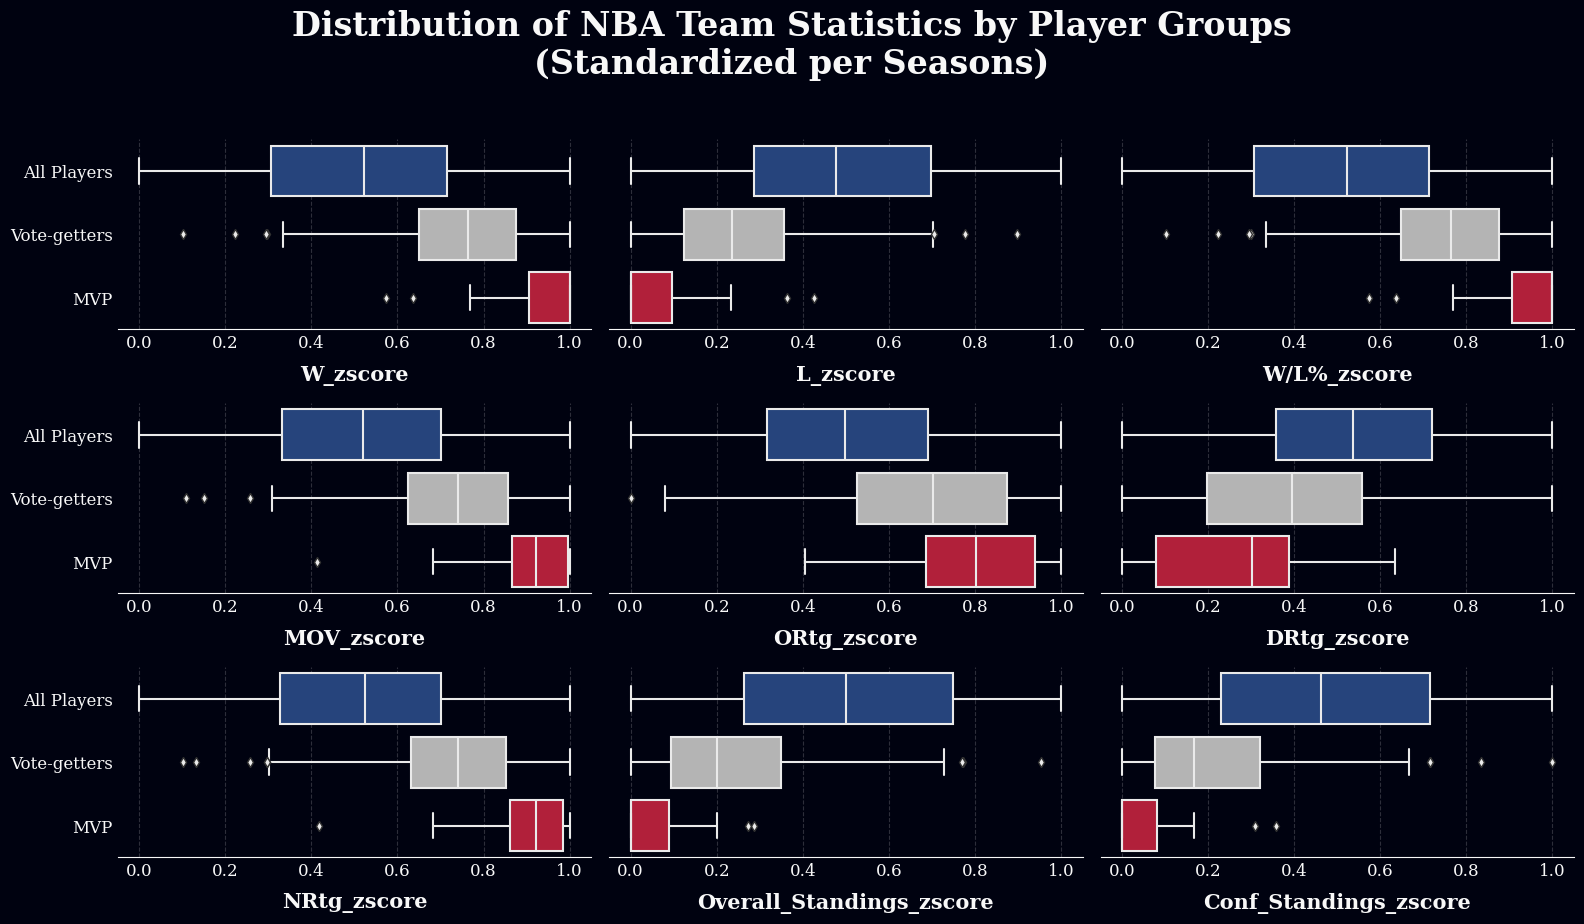

In [91]:
BoxPlots(viz_nba, col_start=50, col_end=59, axrows=3, axcols=3, fig_x=16, fig_y=9, 
         title="Distribution of NBA Team Statistics by Player Groups\n(Standardized per Seasons)")

**Key Points:**
- **The standarized team statistics underscore the importance of MVP-caliber players in driving team success, as evidenced by their ability to lead their teams to higher win totals, lower losses, and better win-loss percentages, positioning them as frontrunners and contenders for championships.**
- These results emphasize the value of MVP recognition in acknowledging the contributions of top-tier players to their teams' overall performance and success in the NBA.
- Teams with MVP winners consistently occupy the 80th percentile or higher in both overall and conference standings. This trend underscores the transformative impact of elite players on team dynamics, performance, and success in the highly competitive environment of the NBA.

### ⚙️ Team Stats - Feature Engineering

Let's examine the graph below.

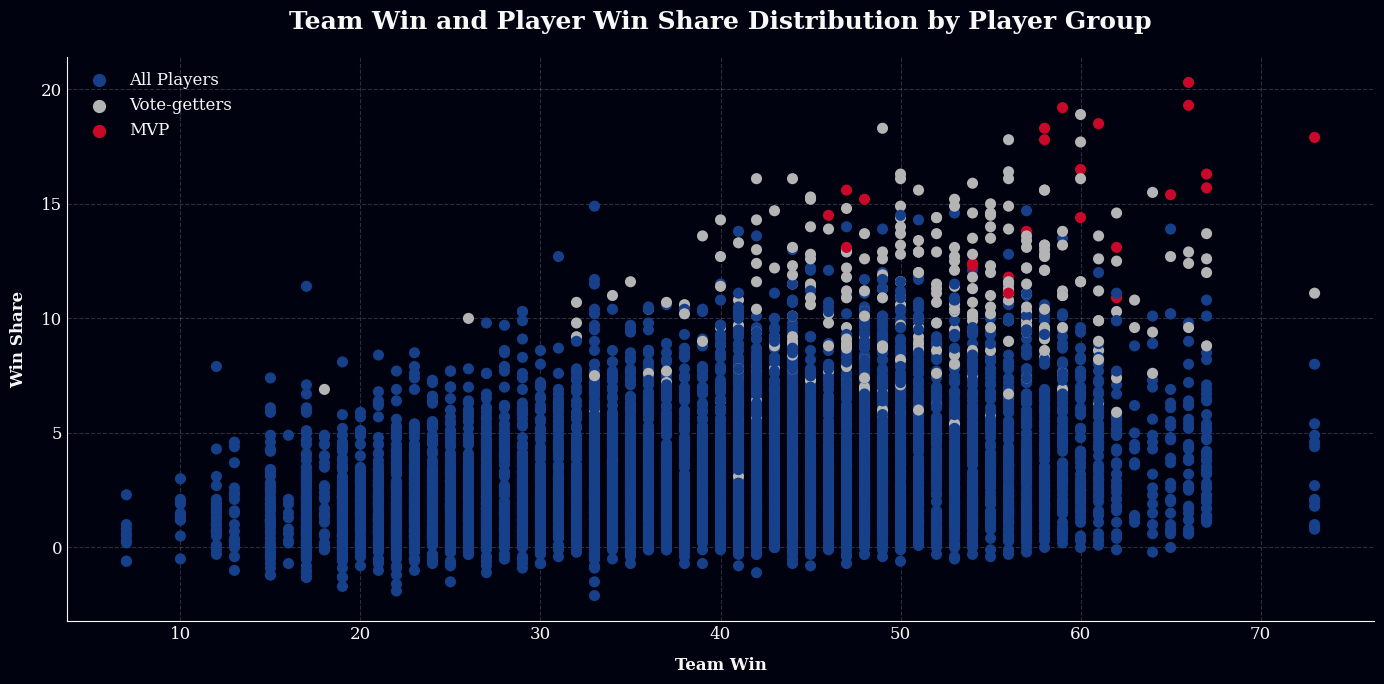

In [92]:
fig, ax = plt.subplots(figsize=(14, 7))
colors = ['#17408B' ,'#B4B4B4', '#C9082A']
order = ['All Players', 'Vote-getters', 'MVP']
sns.scatterplot(x='W', y='WS', data=df_nba, hue='player_groups', palette=colors, hue_order=order, linewidth=0)
plt.xlabel('Team Win')
plt.ylabel('Win Share')
plt.xlim()
plt.legend()
plt.title('Team Win and Player Win Share Distribution by Player Group', fontsize=18, pad=20,fontweight='bold')

plt.tight_layout()
sns.despine()

All players from the same team will be credited with the same number of wins (`W`), losses (`L`), standings, and all other team stats. This can hinder the model's ability to predict the MVP because all these stats can credit end-of-the-bench players with the same stats as their star players. Therefore, these stats will be modified to be useful for the model.

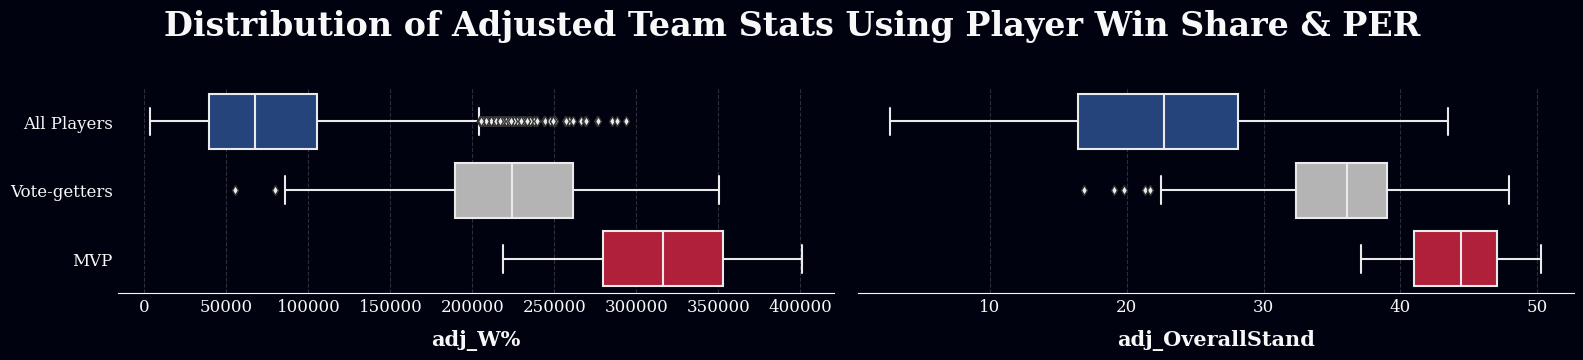

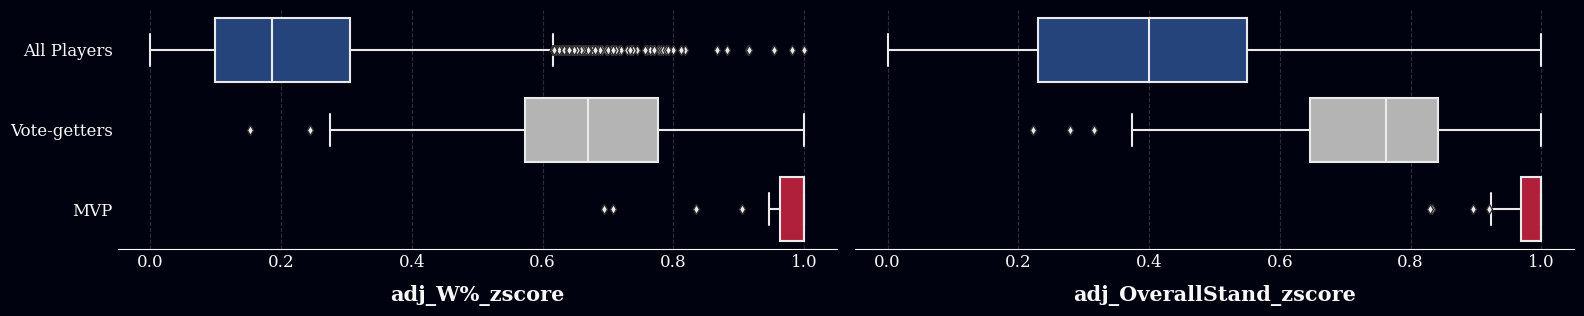

In [93]:
#player contribution to team winning percentage
df_nba['adj_W%'] = df_nba['W/L%'] * 100 * (df_nba['Total_BStat'])
#player contribution to team standing position
df_nba['adj_OverallStand'] = (df_nba['WS']) + (31-df_nba['Overall_Standings'])

StandarizedStats(df_nba, col_begin=df_nba.shape[1]-2, col_end=df_nba.shape[1])

BoxPlots(df_nba, col_start=df_nba.shape[1]-4, col_end=df_nba.shape[1]-2, axrows=1, axcols=2, fig_x=16, fig_y=3.5, 
         title="Distribution of Adjusted Team Stats Using Player Win Share & PER")
BoxPlots(df_nba, col_start=df_nba.shape[1]-2, col_end=df_nba.shape[1], axrows=1, axcols=2, fig_x=16, fig_y=3.5, 
         title="")

### 5. Features Correlation

First, we will apply a penalty to all players who won the MVP in the last year and the two previous years. Although this cannot be solely attributed to *NBA voter fatigue*, our analysis and visualization suggest a significant effect on the MVP winner's likelihood of repeating the win the following year.

In [94]:
df_feat = df_nba.reset_index(drop=True).copy()

In [95]:
cols = ['MP_zscore', 'PTS_zscore', 'TRB_zscore', 'AST_zscore', 'TOV_zscore',
        'eFG%_zscore', 'PER_zscore', 'WS_zscore', 'Total_BStat_zscore',
        'Pos_BStat_zscore', 'DEF_zscore', 'Pos_DEF_zscore', 'BPM_zscore', 'Total_AdvStat_zscore', 
        'adj_TS%_zscore', 'adj_USG%_zscore', 'adj_W%_zscore', 'adj_OverallStand_zscore']

for i in range(df_feat.shape[0]):
    if df_feat.loc[i, 'last_two_season_mvp'] == True:
        df_feat.loc[i, cols] = df_feat.loc[i, cols] * 0.9
    elif df_feat.loc[i, 'last_season_mvp'] == True:
        df_feat.loc[i, cols] = df_feat.loc[i, cols] * 0.95

Before conducting feature correlation analysis, we will drop several statistical columns that we believe have similar implications and similar data distributions, as observed in previous visualizations, to avoid redundant data for the model.

In [96]:
target = df_feat['Vote_Share']

df_model = df_feat.drop(columns=['Player', 'Team', 'G', 'MP', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'FG%', '3P%', 'FT%', 'eFG%', 'PER', 'TS%',
                               'USG%', 'WS', 'OBPM', 'DBPM', 'W', 'L', 'W/L%', 'MOV', 'ORtg', 'DRtg', 'NRtg', 'Overall_Standings', 'Conf_Standings', 
                               'G_zscore', 'STL_zscore', 'BLK_zscore', 'FG%_zscore', '3P%_zscore', 'FT%_zscore', 'OBPM_zscore', 'TS%_zscore', 
                               'USG%_zscore', 'DBPM_zscore', 'W_zscore', 'L_zscore', 'W/L%_zscore', 'Total_AdvStat', 'MOV_zscore', 'ORtg_zscore', 
                               'DRtg_zscore', 'NRtg_zscore', 'Overall_Standings_zscore', 'Conf_Standings_zscore', 'MVP_rank', 'Vote_Share', 'Pos_BStat',
                               'prior_mvp_winner', 'last_season_mvp', 'total_mvp_currently', 'player_groups', 'Total_BStat', 'DEF', 'Pos_DEF', 'BPM', 
                               'adj_TS%', 'adj_USG%', 'adj_W%', 'adj_OverallStand', 'last_two_season_mvp'
                               ])
df_model['Vote_Share'] = target
df_model.reset_index(drop=True, inplace=True)
StandarizedStats(df_model, col_begin=df_model.shape[1]-1, col_end=df_model.shape[1])
df_model['Vote_Share_zscore'] = round(df_model['Vote_Share_zscore'] * 100, 2)
df_model.drop('Vote_Share', axis=1, inplace=True)

In [97]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in df_model.columns:
    if df_model[col].dtype == 'O':
        df_model[col] = le.fit_transform(df_model[col])

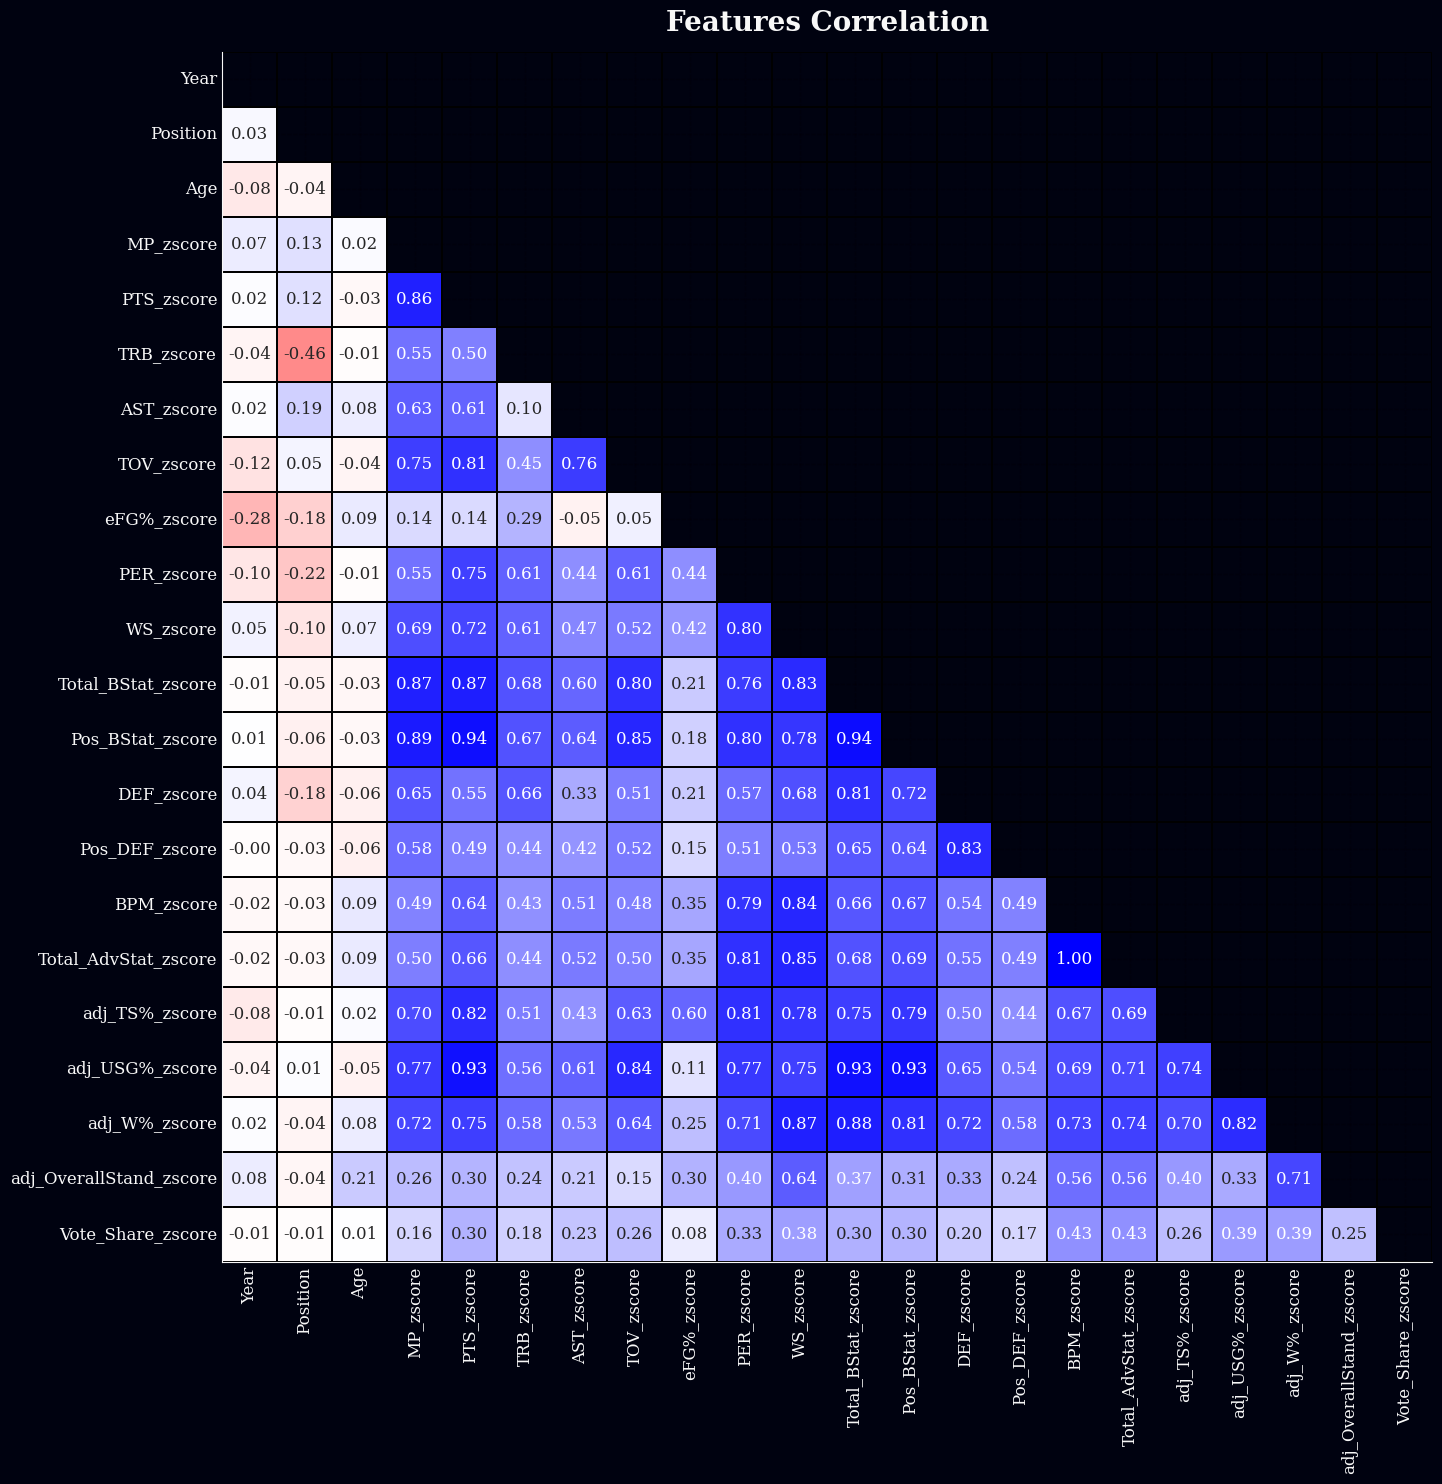

In [100]:
mask = np.zeros_like(df_model.corr(), dtype=bool)
mask[np.triu_indices_from(mask)] = True
plt.rcParams.update({'grid.color': 'black'})
plt.subplots(figsize=(15,15))
sns.heatmap(df_model.corr(),
           annot=True,
           mask=mask,
           cmap='bwr_r',
           linewidths=1.2,
           linecolor='black',
           fmt='.2f',
           center=0,
           square=True,
           cbar=False)
plt.title('Features Correlation', y=1, size=20);
plt.tight_layout()
sns.despine()

# Predictive Modeling
---

To predict the NBA MVP from this dataset, three models will be compared: Random Forest, XGBoost, and Extra Trees Regressor. The best-performing model will then be used for predicting and tracking the current season's NBA MVP. Given the imbalanced nature of the target variable, which often includes many zero values, the Root Mean Squared Logarithmic Error (RMSLE) will be used as the scoring metric.

In [101]:
custom_sns(False)

In [102]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score, KFold
from sklearn.metrics import make_scorer, r2_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint

In [103]:
# Define RMSLE as a custom scoring function
def rmsle(y_true, y_pred):
    """
    Compute Root Mean Squared Logarithmic Error (RMSLE) between true and predicted values.
    """
    return np.sqrt(np.mean((np.log1p(y_true) - np.log1p(y_pred))**2))

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

In [104]:
def predict(model, param_dist, fold=5):

    data = df_model[~df_model['Year'].isin([2024])]
    target = 'Vote_Share_zscore' 
    X = data.drop(columns=[target])
    y = data[target]
    
    model_ = model(random_state=42)
    
    kfold = KFold(n_splits=fold, shuffle=True, random_state=42)
    
    random_search = RandomizedSearchCV(estimator=model_, param_distributions=param_dist, n_iter=20, cv=kfold,
                                       scoring=rmsle_scorer, random_state=42, n_jobs=-1)
    
    random_search.fit(X, y)
    
    best_params = random_search.best_params_
    print(model)
    print("Best Hyperparameters:", best_params)
    
    best_model = random_search.best_estimator_
    
    best_model.fit(X, y)
    
    y_pred = best_model.predict(X)
    
    rmsle_score = rmsle(y, y_pred)
    r2_score_val = r2_score(y, y_pred)
    
    print("RMSLE score of the best model:", rmsle_score)
    print("R-squared score of the best model:", r2_score_val)

    return best_model

## ⦿ Random Forest Regressor

In [105]:
param_dist = {
            'n_estimators': randint(50, 200),
            'max_depth': randint(5, 20),
            'min_samples_split': randint(2, 20),
            'min_samples_leaf': randint(1, 10),
            'max_features': ['auto', 'sqrt', 'log2']
            }

rf = predict(RandomForestRegressor, param_dist, 10)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
Best Hyperparameters: {'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 100}
RMSLE score of the best model: 0.2333684412704089
R-squared score of the best model: 0.906338565341445


## ⦿ Extra Trees Regressor

In [106]:
param_dist = {'n_estimators': randint(50, 200),
                'max_depth': [None] + list(range(5, 20)),
                'min_samples_split': randint(2, 20),
                'min_samples_leaf': randint(1, 10),
                'max_features': ['auto', 'sqrt', 'log2']}

xtree = predict(ExtraTreesRegressor, param_dist, 10)

<class 'sklearn.ensemble._forest.ExtraTreesRegressor'>
Best Hyperparameters: {'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 100}
RMSLE score of the best model: 0.2408950450111805
R-squared score of the best model: 0.9087706822470343


## ⦿ XGBoost

In [107]:
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 10),
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0, 0.1, 0.5, 1.0],
    'min_child_weight': [1, 3, 5, 7],}

xgb = predict(XGBRegressor, param_dist, 10)

<class 'xgboost.sklearn.XGBRegressor'>
Best Hyperparameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 63, 'reg_alpha': 0.5, 'reg_lambda': 1.0, 'subsample': 0.9}
RMSLE score of the best model: 0.1559510891215013
R-squared score of the best model: 0.9705901485340167


**Based on the RMSLE and R-squared scores, the top-performing model among the three is XGBoost, achieving an RMSLE of 0.16 and an R-squared of 0.97. The hyperparameters used to achieve these scores are as follows:**
- **colsample_bytree: 1.0**
- **gamma: 0.1**
- **learning_rate: 0.05**
- **max_depth: 6**
- **min_child_weight: 3**
- **n_estimators: 63**
- **reg_alpha: 0.5**
- **reg_lambda: 1.0**
- **subsample: 0.9**

## ⦿ Model Prediction

To further confirm XGBoost as the optimal model for predicting the NBA MVP, we will compare the predictions from all three models. Let's proceed to the comparison.

In [109]:
# Store all actual MVPs for comparison with the model predictions.
all_pred = df_nba[['Year', 'Player', 'MVP_rank', 'Vote_Share']]
all_pred.rename(columns={'MVP_rank':'MVPrank', 'Vote_Share':'VoteShare'}, inplace=True)
mvp_idx = all_pred.groupby('Year')['VoteShare'].idxmax()
all_pred = all_pred.loc[mvp_idx].reset_index(drop=True)
for i in range(all_pred.shape[0]):
    if all_pred.loc[i, 'Year'] == 2024:
        all_pred.loc[i, ['Player', 'MVPrank', 'VoteShare']] = None

# Merge prediction from each model
models = {'rf':rf, 'xtree':xtree, 'xgb':xgb}
for model in models:
    temp = df_nba[['Year', 'Player', 'MVP_rank']]
    temp.rename(columns={'MVP_rank':'MVPrank'}, inplace=True)
    temp['VoteShare'] = models[model].predict(df_model.drop(columns='Vote_Share_zscore'))
    max_idx = temp.groupby('Year')['VoteShare'].idxmax()
    pred_mvp = temp.loc[max_idx]
    pred_mvp['VoteShare'] = pred_mvp['VoteShare'].apply(lambda x: round(x, 2))
    all_pred = all_pred.merge(pred_mvp, how='left', on=['Year'], suffixes=('', f'_{model.upper()}'))

In [110]:
all_pred

Year                 Player  MVPrank  VoteShare              Player_RF  \
0   2001          Allen Iverson      1.0       90.4       Shaquille O'Neal   
1   2002             Tim Duncan      1.0       75.7             Tim Duncan   
2   2003             Tim Duncan      1.0       80.8             Tim Duncan   
3   2004          Kevin Garnett      1.0       99.1          Kevin Garnett   
4   2005             Steve Nash      1.0       83.9          Dirk Nowitzki   
5   2006             Steve Nash      1.0       73.9           LeBron James   
6   2007          Dirk Nowitzki      1.0       88.2          Dirk Nowitzki   
7   2008            Kobe Bryant      1.0       87.3             Chris Paul   
8   2009           LeBron James      1.0       96.9           LeBron James   
9   2010           LeBron James      1.0       98.0           LeBron James   
10  2011           Derrick Rose      1.0       97.7           Derrick Rose   
11  2012           LeBron James      1.0       88.8           LeBron James   
12  2013           LeBron James      1.0       99.8           LeBron James   
13  2014           Kevin Durant      1.0       98.6           Kevin Durant   
14  2015          Stephen Curry      1.0       92.2          Stephen Curry   
15  2016          Stephen Curry      1.0      100.0          Stephen Curry   
16  2017      Russell Westbrook      1.0       87.9           James Harden   
17  2018           James Harden      1.0       95.5           James Harden   
18  2019  Giannis Antetokounmpo      1.0       93.2  Giannis Antetokounmpo   
19  2020  Giannis Antetokounmpo      1.0       95.2  Giannis Antetokounmpo   
20  2021          Nikola Jokić      1.0       96.1          Nikola Jokić   
21  2022          Nikola Jokić      1.0       87.5          Nikola Jokić   
22  2023            Joel Embiid      1.0       91.5            Joel Embiid   
23  2024                   None      NaN        NaN          Nikola Jokić   

    MVPrank_RF  VoteShare_RF           Player_XTREE  MVPrank_XTREE  \
0            3         75.38       Shaquille O'Neal              3   
1            1         90.34             Tim Duncan              1   
2            1         76.49             Tim Duncan              1   
3            1         91.45          Kevin Garnett              1   
4            3         50.36             Steve Nash              1   
5            2         75.23           LeBron James              2   
6            1         86.58          Dirk Nowitzki              1   
7            2         84.09             Chris Paul              2   
8            1         97.24           LeBron James              1   
9            1         98.78           LeBron James              1   
10           1         83.47           Derrick Rose              1   
11           1         97.64           LeBron James              1   
12           1         98.07           LeBron James              1   
13           1         91.34           Kevin Durant              1   
14           1         91.89          Stephen Curry              1   
15           1         96.52          Stephen Curry              1   
16           2         86.78           James Harden              2   
17           1         95.39           James Harden              1   
18           1         90.85  Giannis Antetokounmpo              1   
19           1         94.53  Giannis Antetokounmpo              1   
20           1         97.55          Nikola Jokić              1   
21           1         97.29          Nikola Jokić              1   
22           1         84.65            Joel Embiid              1   
23           0         93.25          Nikola Jokić              0   

    VoteShare_XTREE             Player_XGB  MVPrank_XGB  VoteShare_XGB  
0             74.99          Allen Iverson            1          72.15  
1             94.62             Tim Duncan            1          91.40  
2             77.10             Tim Duncan            1          85.28  
3         

**Key Points:**

- Based on the NBA MVP predictions for 2001-2023 winners, the XGBoost model had the best performance, achieving the highest accuracy with 22 correct predictions out of 23 winners. The Extra Trees model made 19 correct predictions, while the Random Forest model made 18 correct predictions.
- Interestingly, all three models incorrectly predicted the MVP for the 2017 season, selecting James Harden instead of Russell Westbrook.
- Moreover, all three models predict Nikola Jokić as the MVP for the current 2024 season (as of March), with a high predicted vote share.
- Overall, the models demonstrated high accuracy in predicting the NBA MVP, with XGBoost leading the pack with an accuracy ratio of 22 out of 23 (95.65%).

Now, let's check the top 10 frontrunners for this current season's MVP.

In [111]:
pred_2024 = df_nba[df_nba['Year'] == 2024][['Year', 'Player', 'Team', 'Age', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'FG%', '3P%', 'FT%', 'TS%', 'PER', 'WS', 'USG%', 'BPM',
                                            'W', 'W/L%', 'Conf_Standings', 'Overall_Standings']]
pred_2024['Predicted_Share'] = xgb.predict(df_model[df_model['Year'] == 2024].drop(columns='Vote_Share_zscore'))
pred_2024['Predicted_Share'] = pred_2024['Predicted_Share'].apply(lambda x: round(x, 2))
pred_2024.sort_values('Predicted_Share', ascending=False).head(10)

Year                   Player Team  Age   PTS   TRB  AST  STL  BLK  \
7788  2024            Nikola Jokić  DEN   28  26.1  12.3  9.0  1.3  0.9   
7733  2024  Shai Gilgeous-Alexander  OKC   25  30.5   5.6  6.3  2.1  0.9   
7644  2024    Giannis Antetokounmpo  MIL   29  30.7  11.3  6.4  1.2  1.0   
7710  2024            Luka Dončić  DAL   24  34.1   9.0  9.8  1.5  0.5   
7909  2024             Jayson Tatum  BOS   25  27.1   8.2  4.9  1.0  0.6   
7704  2024            Anthony Davis  LAL   30  24.6  12.5  3.6  1.2  2.4   
7716  2024             Kevin Durant  PHO   35  27.5   6.6  5.3  0.9  1.3   
7718  2024          Anthony Edwards  MIN   22  26.4   5.5  5.2  1.3  0.6   
7679  2024            Jalen Brunson  NYK   27  27.4   3.6  6.5  0.9  0.2   
7802  2024           Damian Lillard  MIL   33  24.4   4.4  7.0  1.0  0.2   

        FG%    3P%    FT%    TS%   PER    WS  USG%     BPM     W   W/L%  \
7788  0.581  0.352  0.826  0.649  31.0  14.5  29.2  457.52  50.0  0.704   
7733  0.541  0.367  0.872  0.641  29.7  13.9  32.9  319.92  49.0  0.700   
7644  0.616  0.296  0.664  0.655  30.0  12.1  33.0  315.00  46.0  0.648   
7710  0.488  0.376  0.785  0.615  28.3  10.3  36.1  370.26  41.0  0.586   
7909  0.473  0.380  0.831  0.606  22.5   9.5  30.3  189.74  57.0  0.803   
7704  0.558  0.280  0.812  0.620  25.8  10.4  26.5  185.12  39.0  0.549   
7716  0.526  0.414  0.856  0.630  21.8   7.4  29.2  163.68  42.0  0.592   
7718  0.465  0.374  0.831  0.578  19.9   6.7  32.5  134.14  49.0  0.690   
7679  0.475  0.402  0.842  0.588  22.2   8.7  31.5  186.03  42.0  0.600   
7802  0.428  0.360  0.927  0.596  20.1   7.4  28.3   84.24  46.0  0.648   

      Conf_Standings  Overall_Standings  Predicted_Share  
7788               1                  2            96.61  
7733               2                  3            74.91  
7644               2                  5            62.60  
7710               7                 11            28.69  
7909               1                  1            17.13  
7704               8                 13             7.50  
7716               6                 10             5.93  
7718               3                  4             4.32  
7679               4                  9             1.66  
7802               2                  5             1.20

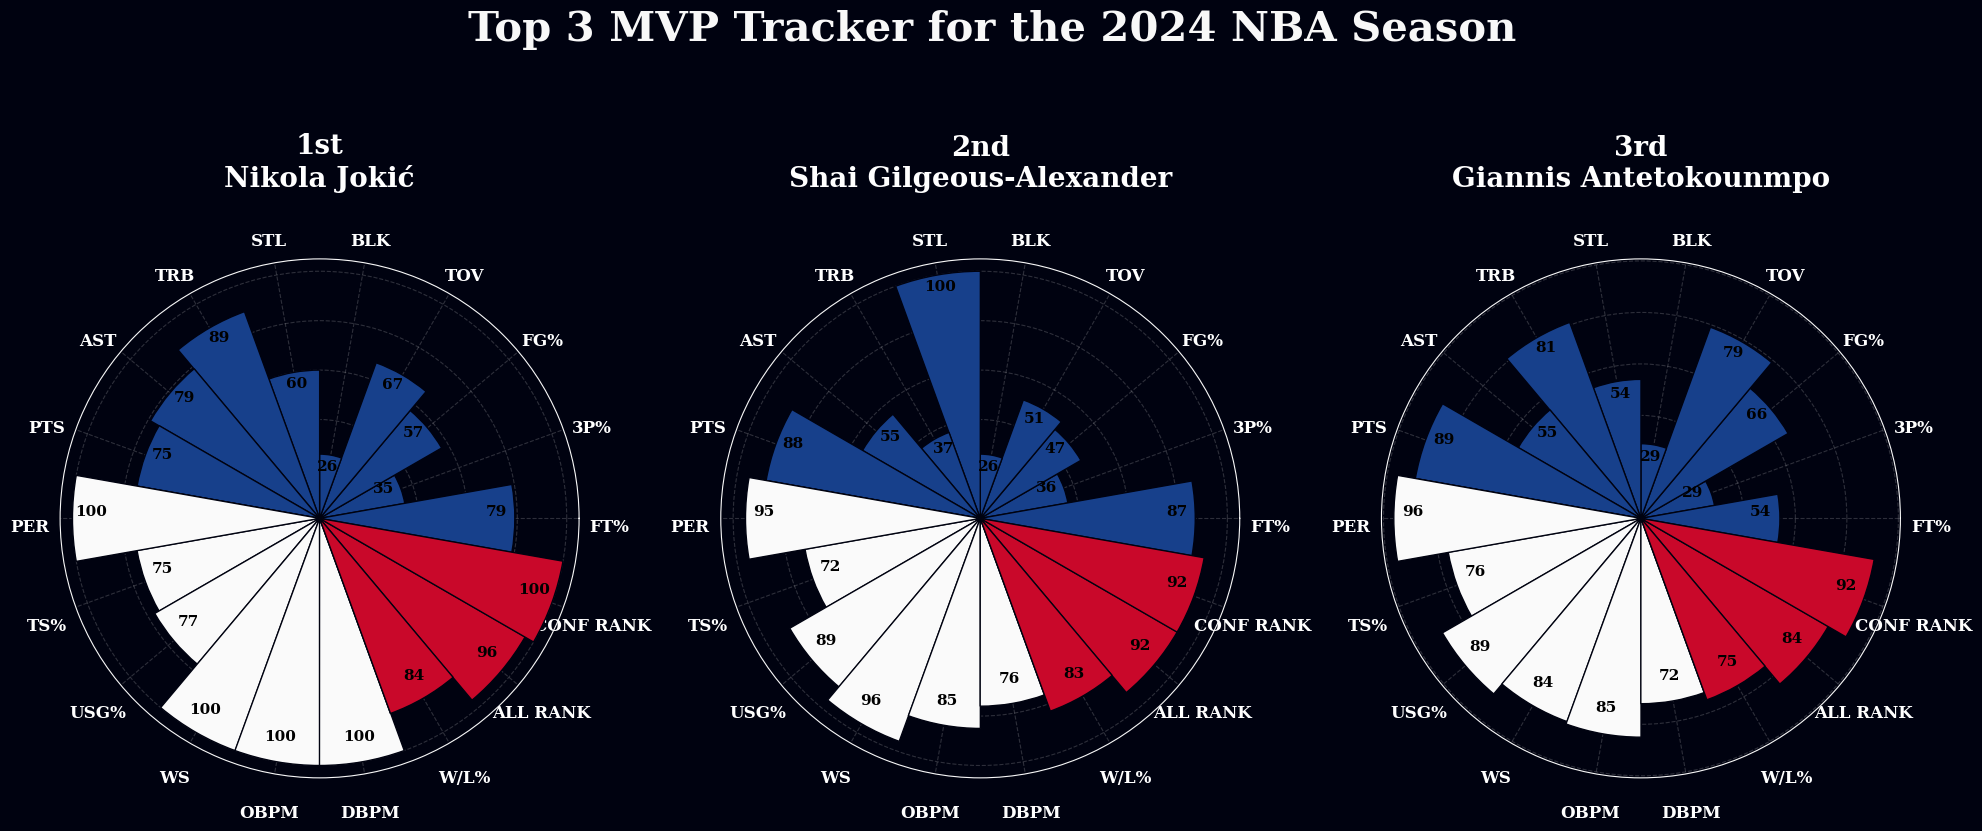

In [115]:
data = df_nba[df_nba['Year'] == 2024]
data['Conf_Standings_zscore'] = 1 - data['Conf_Standings_zscore'] 
data['Overall_Standings_zscore'] = 1 - data['Overall_Standings_zscore']
def radar_chart(ax, groups, labels, values, title):
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    values += values[:1]
    angles += angles[:1]

    for group, (color, group_labels) in groups.items():
        group_indices = [labels.index(label) for label in group_labels]
        group_values = [values[i] for i in group_indices]
        group_angles = [angles[i] for i in group_indices]
        group_values += group_values[:1]
        group_angles += group_angles[:1]
        bars = ax.bar(group_angles, group_values, width=0.35, label=group, color=color, alpha=1, linewidth=1, edgecolor='#000210')
        for angle, value in zip(group_angles[:-1], group_values[:-1]):
            ax.text(angle, value - 7.5, str(value), ha='center', va='bottom', color='#000000', fontsize=11, weight='heavy')

    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=12, fontweight='bold', color='white', verticalalignment='top')
    ax.tick_params(axis='both', which='major', pad=15)

    ax.set_title(title, size=20, color='white', y=1.1)
    if ax == 3:
        ax.legend(loc='upper right', fontsize=12, bbox_to_anchor=(1.3, 1.1))

groups = {
    'Basic Stats': ('#17408B', ['FT%', '3P%', 'FG%', 'TOV', 'BLK', 'STL', 'TRB', 'AST', 'PTS']),
    'Advance Stats': ('#FAFAFA', ['PER', 'TS%', 'USG%', 'WS', 'OBPM', 'DBPM']),
    'Team Stats': ('#C9082A', ['W/L%', 'ALL RANK', 'CONF RANK'])
}
labels = ['FT%', '3P%', 'FG%', 'TOV', 'BLK', 'STL', 'TRB', 'AST', 'PTS', 'PER', 'TS%', 'USG%', 'WS', 'OBPM', 'DBPM', 'W/L%', 'ALL RANK', 'CONF RANK']

fig, axs = plt.subplots(1, 3, figsize=(20, 12), subplot_kw=dict(polar=True))

for i, ax in enumerate(axs):
    top3 = pred_2024.sort_values('Predicted_Share', ascending=False)['Player'].head(3).to_list()
    cols = ['FT%_zscore', '3P%_zscore', 'FG%_zscore', 'TOV_zscore', 'BLK_zscore', 'STL_zscore', 'TRB_zscore', 'AST_zscore', 'PTS_zscore', 'PER_zscore', 
            'TS%_zscore', 'USG%_zscore', 'WS_zscore', 'OBPM_zscore', 'DBPM_zscore', 'W/L%_zscore', 'Overall_Standings_zscore', 'Conf_Standings_zscore']
    mask = list(data[data['Player'] == top3[i]][cols].values[0] * 100)
    values = [int(x) for x in mask]
    places = ['1st', '2nd', '3rd']
    title = f'{places[i]}\n{top3[i]}'
    radar_chart(ax, groups, labels, values, title)

plt.suptitle('Top 3 MVP Tracker for the 2024 NBA Season', fontsize=30, fontweight='bold', y=0.9)
    
plt.tight_layout()
plt.show()

**Key Points (as of March 2024):**

- Nikola Jokić, with the highest PER, WS, and BPM, likely contributes significantly to the model predicting him as the number one of the top 10 MVP frontrunners.
- Shai Gilgeous-Alexander (2nd) and Giannis Antetokounmpo (3rd) still have a chance to move up in the MVP ranking ladder based on their actual basic stats, advanced stats, team standings, and vote share prediction.
- Luka Dončić leads in PTS per game (34.1) this season, with a considerable gap to the second highest, Shai Gilgeous-Alexander (30.9). This contributes to Dončić being in 4th place currently, despite his team's poor standings.

In [121]:
df_ = df_nba.copy()
zscore_columns = [col for col in df_nba.columns if 'zscore' in col]
df_['Conf_Standings_zscore'] = 1 - df_['Conf_Standings_zscore'] 
df_['Overall_Standings_zscore'] = 1 - df_['Overall_Standings_zscore']
df_[zscore_columns] = df_[zscore_columns].applymap(lambda x: round(x * 100, 0))

In [123]:
# Export DataFrame to CSV with UTF-8-SIG encoding
df_.to_csv('nba_mvp.csv', encoding='utf-8-sig', index=False)

## ⦿ Model Interpretation

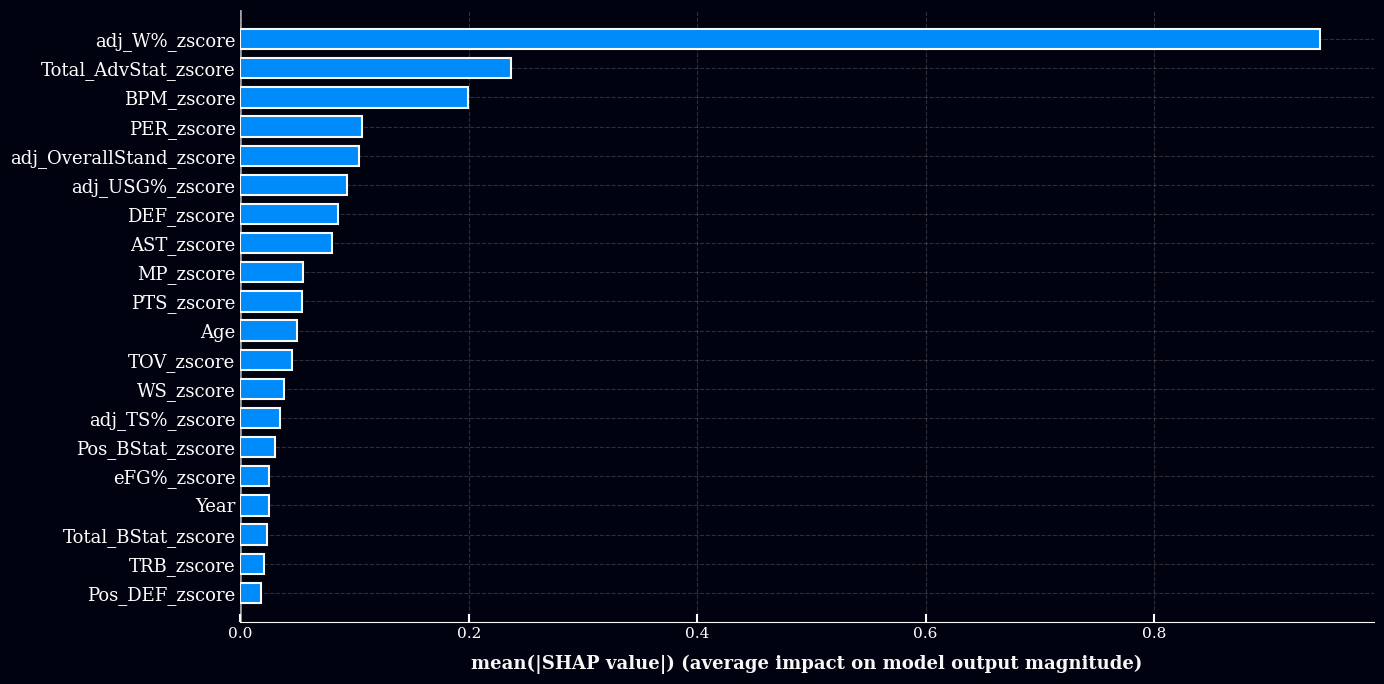

In [125]:
import shap
shap.initjs()

data = df_model[df_model['Year'] != 2024]
target = 'Vote_Share_zscore' 
X = data.drop(columns=[target])
y = data[target]

explainer = shap.Explainer(xgb)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, plot_type='bar', axis_color='white', plot_size=(14, 7))

The feature with the highest impact on the XGBoost model prediction is `adj_W%`, which represents the team's winning percentage adjusted by the total basic stats of the player. The impact gap from this feature to the next feature is considerable. Following closely are the next two impactful features for the model: `Total_AdvStat`, representing the total advanced stats for the player, and adjusted `BPM`, which indicates the Box Plus/Minus of the player.

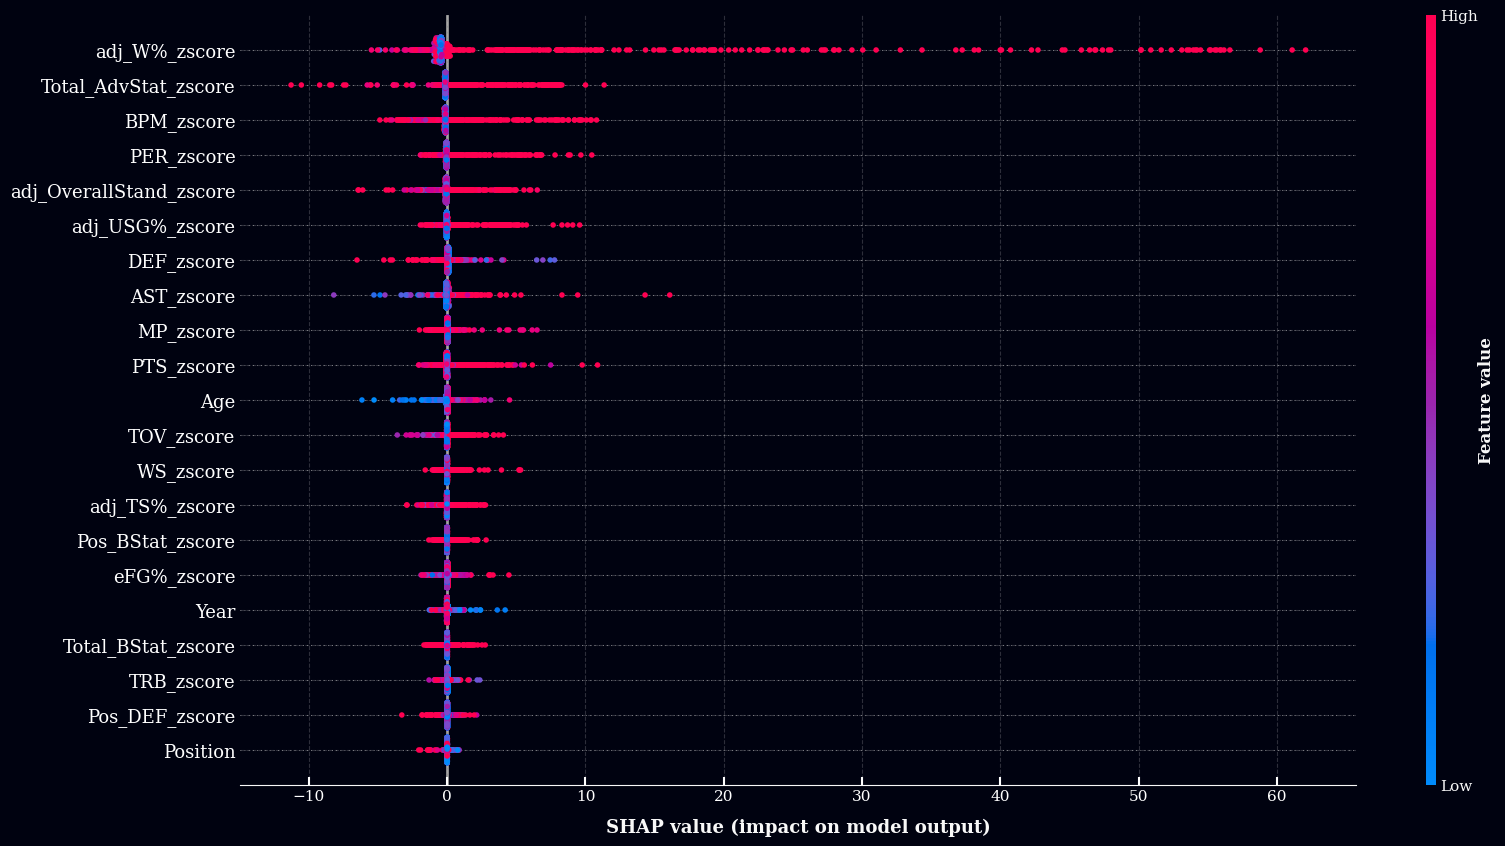

<Figure size 800x600 with 0 Axes>

In [126]:
explainer = shap.Explainer(xgb)
shap_values = explainer(X)
shap.plots.beeswarm(shap_values, axis_color='white', plot_size=(18, 10), max_display=25)
plt.tight_layout()

From the beeswarm plot, we can discern in greater detail the influence of each feature in this model. The plot vividly illustrates the wide range of impact from the `adj_W` feature. Additionally, it's apparent that features with high-value records exert the most influence on the model's predictions. Conversely, most low-value records result in zero impact across all features, except for `AST`, `Age`, and `Year`.

Lastly, the SHAP waterfall plot provides insight into the impact of each feature on the prediction of vote share for each player. Let's utilize this plot to examine the process the model undertook when incorrectly predicting James Harden as the 2017 MVP instead of Russell Westbrook.

In [127]:
df_nba[(df_nba['Player'] == 'James Harden') & (df_nba['Year'] == 2017)]

Year        Player Position  Age Team   G    MP   PTS  TRB   AST  STL  \
5377  2017  James Harden       PG   27  HOU  81  36.4  29.1  8.1  11.2  1.5   

      BLK  TOV   FG%    3P%    FT%   eFG%   PER    TS%  USG%    WS  OBPM  \
5377  0.5  5.7  0.44  0.347  0.847  0.525  27.4  0.613  34.2  15.0   7.5   

      DBPM     W     L   W/L%   MOV    ORtg    DRtg  NRtg  Overall_Standings  \
5377   1.2  55.0  27.0  0.671  5.77  115.59  109.96  5.63                  3   

      Conf_Standings  G_zscore  MP_zscore  PTS_zscore  TRB_zscore  AST_zscore  \
5377               3   0.97619   0.954545    0.916388    0.555556         1.0   

      STL_zscore  BLK_zscore  TOV_zscore  FG%_zscore  3P%_zscore  FT%_zscore  \
5377    0.736842    0.192308         1.0    0.323457    0.644981    0.921654   

      eFG%_zscore  PER_zscore  TS%_zscore  USG%_zscore  WS_zscore  \
5377     0.447368    0.873518     0.71519     0.767802        1.0   

      OBPM_zscore  DBPM_zscore  W_zscore  L_zscore  W/L%_zscore  MOV_zscore  \
5377     0.914286     0.602941  0.744681  0.255319     0.745201    0.683414   

      ORtg_zscore  DRtg_zscore  NRtg_zscore  Overall_Standings_zscore  \
5377     0.945528     0.602957     0.676109                  0.095238   

      Conf_Standings_zscore  MVP_rank  Vote_Share  prior_mvp_winner  \
5377               0.153846         2        74.6             False   

      last_season_mvp  last_two_season_mvp  total_mvp_currently player_groups  \
5377            False                False                    0  Vote-getters   

      Total_BStat  Pos_BStat  Total_BStat_zscore  Pos_BStat_zscore    DEF  \
5377       5192.1       51.0            0.939024          0.971574  162.0   

      Pos_DEF  DEF_zscore  Pos_DEF_zscore     BPM  Total_AdvStat  BPM_zscore  \
5377      1.5    0.565857            0.56  316.68        1041.64    0.868084   

      Total_AdvStat_zscore  adj_TS%   adj_USG%  adj_TS%_zscore  \
5377              0.869849     90.4  177569.82         0.97992   

      adj_USG%_zscore     adj_W%  adj_OverallStand  adj_W%_zscore  \
5377         0.769208  348389.91              43.0            1.0   

      adj_OverallStand_zscore  
5377                      1.0

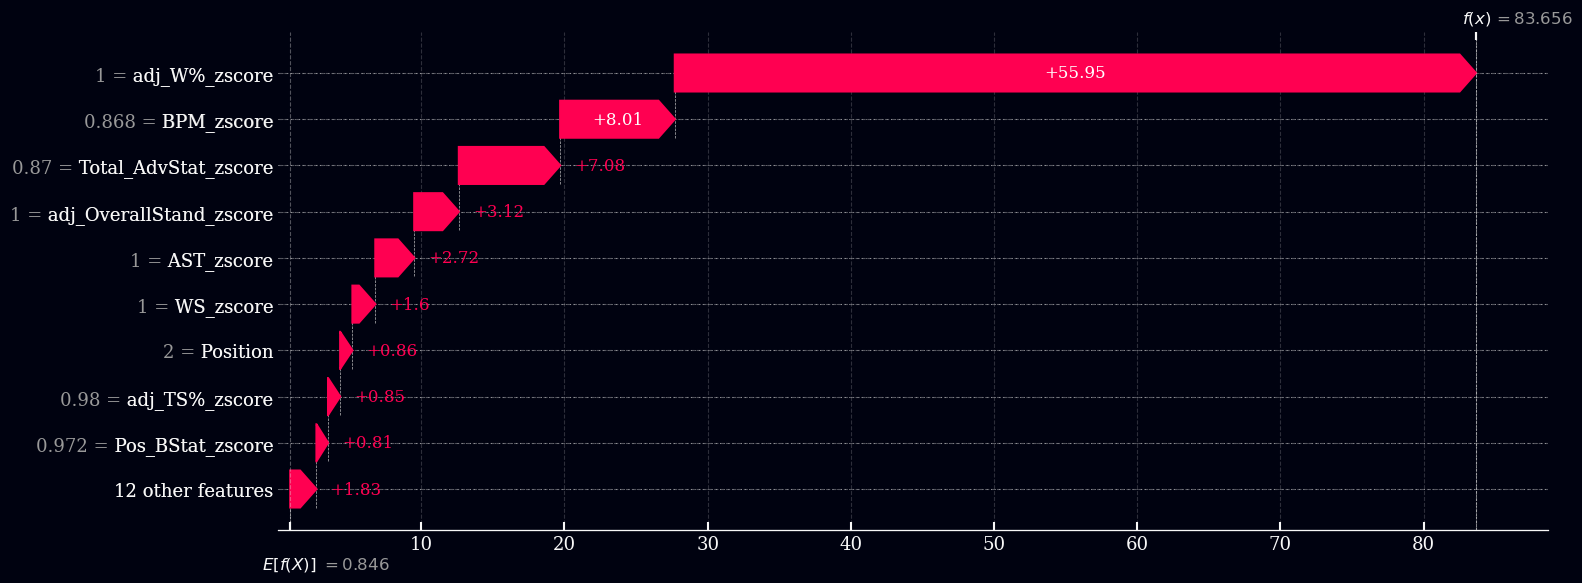

In [128]:
explainer = shap.Explainer(xgb)
shap_values = explainer(X)
shap.plots.waterfall(shap_values[5377], max_display=10, show=False)
ax = plt.gca()
fig = ax.figure
fig.set_size_inches(16, 6)
plt.tight_layout()
plt.show()

In [129]:
df_nba[(df_nba['Player'] == 'Russell Westbrook') & (df_nba['Year'] == 2017)]

Year             Player Position  Age Team   G    MP   PTS   TRB   AST  \
5579  2017  Russell Westbrook       PG   28  OKC  81  34.6  31.6  10.7  10.4   

      STL  BLK  TOV    FG%    3P%    FT%   eFG%   PER    TS%  USG%    WS  \
5579  1.6  0.4  5.4  0.425  0.343  0.845  0.476  30.6  0.554  41.7  13.1   

      OBPM  DBPM     W     L   W/L%   MOV    ORtg    DRtg  NRtg  \
5579   8.7   2.4  47.0  35.0  0.573  0.76  108.95  108.17  0.78   

      Overall_Standings  Conf_Standings  G_zscore  MP_zscore  PTS_zscore  \
5579                  7               5   0.97619   0.896104         1.0   

      TRB_zscore  AST_zscore  STL_zscore  BLK_zscore  TOV_zscore  FG%_zscore  \
5579    0.748148    0.927928    0.789474    0.153846    0.946429     0.28642   

      3P%_zscore  FT%_zscore  eFG%_zscore  PER_zscore  TS%_zscore  \
5579    0.637546    0.919478     0.304094         1.0    0.528481   

      USG%_zscore  WS_zscore  OBPM_zscore  DBPM_zscore  W_zscore  L_zscore  \
5579          1.0   0.879747          1.0     0.779412  0.574468  0.425532   

      W/L%_zscore  MOV_zscore  ORtg_zscore  DRtg_zscore  NRtg_zscore  \
5579     0.574171     0.41275     0.405691     0.413939     0.416889   

      Overall_Standings_zscore  Conf_Standings_zscore  MVP_rank  Vote_Share  \
5579                  0.285714               0.307692         1        87.9   

      prior_mvp_winner  last_season_mvp  last_two_season_mvp  \
5579             False            False                False   

      total_mvp_currently player_groups  Total_BStat  Pos_BStat  \
5579                    0           MVP       5516.1       52.4   

      Total_BStat_zscore  Pos_BStat_zscore    DEF  Pos_DEF  DEF_zscore  \
5579                 1.0               1.0  162.0      1.6    0.565857   

      Pos_DEF_zscore     BPM  Total_AdvStat  BPM_zscore  Total_AdvStat_zscore  \
5579             0.6  384.06        1250.68         1.0                   1.0   

      adj_TS%   adj_USG%  adj_TS%_zscore  adj_USG%_zscore     adj_W%  \
5579     87.0  230021.37        0.911647              1.0  316072.53   

      adj_OverallStand  adj_W%_zscore  adj_OverallStand_zscore  
5579              37.1       0.905289                  0.83046

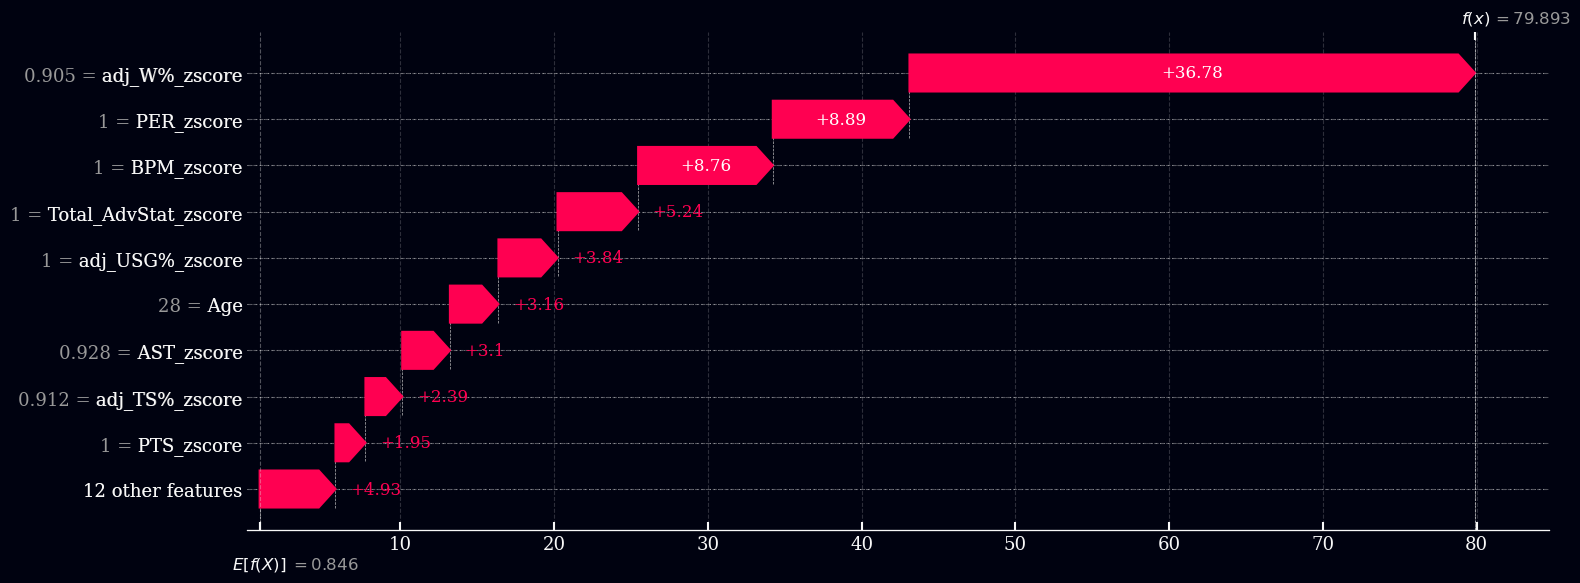

In [130]:
explainer = shap.Explainer(xgb)
shap_values = explainer(X)
shap.plots.waterfall(shap_values[5579], max_display=10, show=False)
ax = plt.gca()
fig = ax.figure
fig.set_size_inches(16, 6)
plt.tight_layout()
plt.show()

Both James Harden and Russell Westbrook had phenomenal seasons, with many top percentile (1) rankings for both players. However, James Harden had the top percentile in the most impactful feature in this model, which is `adj_W%`. From this feature alone, James Harden gained a +55.95% vote share prediction, while Russell Westbrook only gained a +36.78% vote share prediction. Consequently, the difference in the final vote share prediction between both players was only about 4%, but James Harden emerged as the winner according to our model due to the significant gap in gain from `adj_W%`.